# Grape diseases and pests classification

**Chi Tran - CMPE 257**

In [92]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import glob
import time
import numpy as np
import pandas as pd
import math
import seaborn as sns
import random
import shutil
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
import h5py
from tensorflow.keras import models, layers, optimizers 
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.applications import imagenet_utils
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(150)
np.random.seed(150)
tf.random.set_seed(150)

# Displays all outputs of a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 6]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)


TensorFlow version: 2.1.0
Keras version: 2.2.4-tf


## Data structure

I will apply an unsupervised machine learning model to recognize and classify the images. Therefore, Keras ImageDataGenerator is the best choice. As mentioned on the website: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720, my data will be divided into sub-folders that corresponding to image classes under train, validation, and test folders.

<p align='center'>
  ![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
</p>

In [3]:
# Set up main folders to store original images, binary data, and trained models
root = '.'
data = os.path.join(root, 'img_data')
bin_data= os.path.join(root, 'bin_data')
trained_models = os.path.join(root, 'trained_models')

# Original images
phylloxera_fold = os.path.join(data, 'phylloxera')
mealybug_fold = os.path.join(data, 'mealybug')
b_measles_fold = os.path.join(data, 'black_measles')
b_rot_fold = os.path.join(data, 'black_rot')
leaf_blight_fold = os.path.join(data, 'leaf_blight')
healthy = os.path.join(data, 'healthy')

# Define train, validation, and test folders
train_fold = os.path.join(data, 'train')
val_fold = os.path.join(data, 'validation')
test_fold = os.path.join(data, 'test')

# Create sub-folders for each class in train folder
train_phylloxera = os.path.join(train_fold, 'phylloxera')
train_mealybug = os.path.join(train_fold, 'mealybug')
train_b_measles = os.path.join(train_fold, 'black_measles')
train_b_rot = os.path.join(train_fold, 'black_rot')
train_leaf_blight = os.path.join(train_fold, 'leaf_blight')
train_healthy = os.path.join(train_fold, 'healthy')

# Create sub-folders for each class in validation folder
val_phylloxera = os.path.join(val_fold, 'phylloxera')
val_mealybug = os.path.join(val_fold, 'mealybug')
val_b_measles = os.path.join(val_fold, 'black_measles')
val_b_rot = os.path.join(val_fold, 'black_rot')
val_leaf_blight = os.path.join(val_fold, 'leaf_blight')
val_healthy = os.path.join(val_fold, 'healthy')

# Create sub-folders for each class in test folder
test_phylloxera = os.path.join(test_fold, 'phylloxera')
test_mealybug = os.path.join(test_fold, 'mealybug')
test_b_measles = os.path.join(test_fold, 'black_measles')
test_b_rot = os.path.join(test_fold, 'black_rot')
test_leaf_blight = os.path.join(test_fold, 'leaf_blight')
test_healthy = os.path.join(test_fold, 'healthy')


In [4]:
# Create folders to store original images, binary data, and trained models
os.mkdir(data)
os.mkdir(bin_data)
os.mkdir(trained_models)

# Create train, validation, and test folders
os.mkdir(train_fold)
os.mkdir(val_fold)
os.mkdir(test_fold)

# Create sub-folders for each class inside the train folder
os.mkdir(train_phylloxera)
os.mkdir(train_mealybug)
os.mkdir(train_b_measles)
os.mkdir(train_b_rot)
os.mkdir(train_leaf_blight)
os.mkdir(train_healthy)

# Create sub-folders for each class inside the validation folder
os.mkdir(val_phylloxera)
os.mkdir(val_mealybug)
os.mkdir(val_b_measles)
os.mkdir(val_b_rot)
os.mkdir(val_leaf_blight)
os.mkdir(val_healthy)

# Create sub-folders for each class inside the test folder
os.mkdir(test_phylloxera)
os.mkdir(test_mealybug)
os.mkdir(test_b_measles)
os.mkdir(test_b_rot)
os.mkdir(test_leaf_blight)
os.mkdir(test_healthy)

## Build Dataset from original data

### Collect Images in each class

In [4]:
total_phylloxera = len(os.listdir(phylloxera_fold))
total_mealybug = len(os.listdir(mealybug_fold))
total_b_measles = len(os.listdir(b_measles_fold))
total_b_rot = len(os.listdir(b_rot_fold))
total_leaf_blight = len(os.listdir(leaf_blight_fold))
total_healthy = len(os.listdir(healthy))

total_images = total_phylloxera + total_mealybug + total_b_measles + total_b_rot + total_leaf_blight + total_healthy
                                   
print('Total Images: {}'.format(total_images))
print('There are {} images in phylloxera class'.format(total_phylloxera))
print('There are {} images in mealybug class'.format(total_mealybug))
print('There are {} images in black measles class'.format(total_b_measles))
print('There are {} images in black rot class'.format(total_b_rot))
print('There are {} images in leaf blight class'.format(total_leaf_blight))
print('There are {} images in healthy class'.format(total_healthy))


Total Images: 4796
There are 200 images in phylloxera class
There are 534 images in mealybug class
There are 1383 images in black measles class
There are 1180 images in black rot class
There are 1076 images in leaf blight class
There are 423 images in healthy class


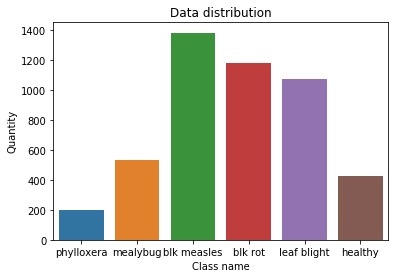

In [5]:
# Show data distribution using bar charts
data_col = pd.DataFrame.from_dict(data={ 'phylloxera': [total_phylloxera],
                                        'mealybug': [total_mealybug],
                                         'blk measles': [total_b_measles],
                                          'blk rot': [total_b_rot],
                                          'leaf blight': [total_leaf_blight],
                                          'healthy': [total_healthy]
                                          } )
sns.barplot(data=data_col);
plt.xlabel('Class name');
plt.ylabel('Quantity');
plt.title('Data distribution');

### Rename Images
The model may not be able to read a file with a very long name, so that all images should be named using a naming convention.

In [6]:
def rename_images(path, image_class):
  """
  Standardize file names.
  @param path - the path to the image directory
  @param image_class - name of the image class, such as black measles or black rot
  """
  for i, image in enumerate(os.listdir(path)):
    name = image_class + str(i) + '.jpg'
    source = os.path.join(path, image)
    dest = os.path.join(path, name)
    os.rename(source, dest)
  print('Finish renaming.')

In [63]:
# Rename images in each folder
rename_images(phylloxera_fold, image_class='phylloxera')
rename_images(mealybug_fold, image_class='mealybug')
rename_images(b_measles_fold, image_class='black_measles')
rename_images(b_rot_fold, image_class='black_rot')
rename_images(leaf_blight_fold, image_class='leaf_blight')
rename_images(healthy, image_class='healthy')


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '.\\data\\black_measles\\black_measles10.jpg' -> '.\\data\\black_measles\\black_measles2.jpg'

### Shuffle and split data into train, validation and test folder

Data will be splited based on the following rule: 80% of data for training and 20% for test. Afterwards, the training set will be divided into 80% training and 20% validation.

In [7]:
def train_test_split_data(data_source, class_name, val_size=0.2, test_size=0.2):
  
  assert class_name in ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy'], \
    "Class name is invalid!"
  
  train_folder = os.path.join(data_source, 'train', class_name)
  val_folder = os.path.join(data_source, 'validation', class_name)
  test_folder = os.path.join(data_source, 'test', class_name)
  
  assert len(os.listdir(train_folder)) == 0, "Training directory must be empty."
  assert len(os.listdir(val_folder)) == 0, "Validation directory must be empty."
  assert len(os.listdir(test_folder)) == 0, "Test directory must be empty."
  
  path = os.path.join(data_source, class_name)
  total = len(os.listdir(path))
  
  # Shuffle the data
  data = os.listdir(path)
  random.shuffle(data)
  
  # Split train and test data: 80-20
  total_train = math.floor(total*0.8)
  total_test = total - total_train
  
  # Split train-validation data from train data: 80-20
  total_val = math.floor(total_train*0.2)
  total_train = total_train - total_val
  
  # Set data index
  train_dat = data[:total_train]
  val_dat = data[total_train:total_train+total_val]
  test_dat = data[total_train+total_val:]
    
  # Copy training data
  for file in train_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(train_folder, file)
    shutil.copyfile(source, dest)
    
  # Copy validation data
  for file in val_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(val_folder, file)
    shutil.copyfile(source, dest)
    
  # Copy test data
  for file in test_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(test_folder, file)
    shutil.copyfile(source, dest)

### Split data

In [9]:
for class_name in ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy']:
  train_test_split_data(data, class_name)

Checking data allocation after spliting

In [5]:
# Checking data
total_train_phylloxera = len(os.listdir(train_phylloxera))
total_train_mealybug = len(os.listdir(train_mealybug))
total_train_b_measles = len(os.listdir(train_b_measles))
total_train_b_rot = len(os.listdir(train_b_rot))
total_train_leaf_blight = len(os.listdir(train_leaf_blight))
total_train_healthy = len(os.listdir(train_healthy))

total_valid_phylloxera = len(os.listdir(val_phylloxera))
total_valid_mealybug = len(os.listdir(val_mealybug))
total_valid_b_measles = len(os.listdir(val_b_measles))
total_valid_b_rot = len(os.listdir(val_b_rot))
total_valid_leaf_blight = len(os.listdir(val_leaf_blight))
total_valid_healthy = len(os.listdir(val_healthy))

total_test_phylloxera = len(os.listdir(test_phylloxera))
total_test_mealybug = len(os.listdir(test_mealybug))
total_test_b_measles = len(os.listdir(test_b_measles))
total_test_b_rot = len(os.listdir(test_b_rot))
total_test_leaf_blight = len(os.listdir(test_leaf_blight))
total_test_healthy = len(os.listdir(test_healthy))

total_train = total_train_b_measles + total_train_b_rot + \
                total_train_leaf_blight + total_train_healthy + total_train_phylloxera + total_train_mealybug
total_valid = total_valid_b_measles + total_valid_b_rot + \
              total_valid_leaf_blight + total_valid_healthy + total_valid_phylloxera + total_valid_mealybug
total_test = total_test_b_measles + total_test_b_rot + \
              total_test_leaf_blight + total_test_healthy + total_test_phylloxera + total_test_mealybug

def check_dist(total, phylloxera, mealybug, black_measles, black_rot, leaf_blight, healthy):
  print('Phylloxera class occupies: {:.2f}%'.format((phylloxera / total)*100.0))
  print('Mealybug class occupies: {:.2f}%'.format((mealybug / total)*100.0))
  print('Black measles class occupies: {:.2f}%'.format((black_measles/total)*100.0))
  print('Black rot class occupies: {:.2f}%'.format((black_rot / total)*100))
  print('Left blight class occupies: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('Healthy class occupies: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_valid + total_test)
print('Total phylloxera:', total_train_phylloxera + total_valid_phylloxera + total_test_phylloxera)
print('Total mealybug:', total_train_mealybug + total_valid_mealybug + total_test_mealybug)
print('Total black measles:', total_train_b_measles + total_valid_b_measles + total_test_b_measles)
print('Total black rot:', total_train_b_rot + total_valid_b_rot + total_test_b_rot)
print('Total leaf blight:', total_train_leaf_blight + total_valid_leaf_blight + total_test_leaf_blight)
print('Total healthy:', total_train_healthy + total_valid_healthy + total_test_healthy)
print()

print('Total of training phylloxera images:', total_train_phylloxera)
print('Total of training mealybug images:', total_train_mealybug)
print('Total of training black measles images:', total_train_b_measles)
print('Total of training black rot images:', total_train_b_rot)
print('Total of training leaf blight images:', total_train_leaf_blight)
print('Total of training healthy images:', total_train_healthy)
print()

print('Total of validation phylloxera images:', total_valid_phylloxera)
print('Total of validation mealybug images:', total_valid_mealybug)
print('Total of validation black measles images:', total_valid_b_measles)
print('Total of validation black rot images:', total_valid_b_rot)
print('Total of validation leaf blight images:', total_valid_leaf_blight)
print('Total of validation healthy images:', total_valid_healthy)
print()

print('Total of test phylloxera images:', total_test_phylloxera)
print('Total of test mealybug images:', total_test_mealybug)
print('Total of test black measles images:', total_test_b_measles)
print('Total of test black rot images:', total_test_b_rot)
print('Total of test leaf blight images:', total_test_leaf_blight)
print('Total of test healthy images:', total_test_healthy)
print()

print('Training distribution')
check_dist(total_train, total_train_b_measles, total_train_b_rot,
                    total_train_leaf_blight, total_train_healthy, total_train_phylloxera, total_train_mealybug)
print('Validation distribution')
check_dist(total_valid, total_valid_b_measles, total_valid_b_rot,
                    total_valid_leaf_blight, total_valid_healthy, total_valid_phylloxera, total_valid_mealybug)
print('Test distribution')
check_dist(total_test, total_test_b_measles, total_test_b_rot,
                    total_test_leaf_blight, total_test_healthy, total_test_phylloxera, total_test_mealybug)


Total images: 4796
Total phylloxera: 200
Total mealybug: 534
Total black measles: 1383
Total black rot: 1180
Total leaf blight: 1076
Total healthy: 423

Total of training phylloxera images: 128
Total of training mealybug images: 343
Total of training black measles images: 886
Total of training black rot images: 756
Total of training leaf blight images: 689
Total of training healthy images: 272

Total of validation phylloxera images: 32
Total of validation mealybug images: 85
Total of validation black measles images: 221
Total of validation black rot images: 188
Total of validation leaf blight images: 172
Total of validation healthy images: 67

Total of test phylloxera images: 40
Total of test mealybug images: 106
Total of test black measles images: 276
Total of test black rot images: 236
Total of test leaf blight images: 215
Total of test healthy images: 84

Training distribution
Phylloxera class occupies: 28.82%
Mealybug class occupies: 24.59%
Black measles class occupies: 22.41%
Blac

## Data Analysis

### Observe Data Images

In [6]:
def read_data(path, size):
  img = image.load_img(path, target_size=size)
  img = image.img_to_array(img)
  return img

C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


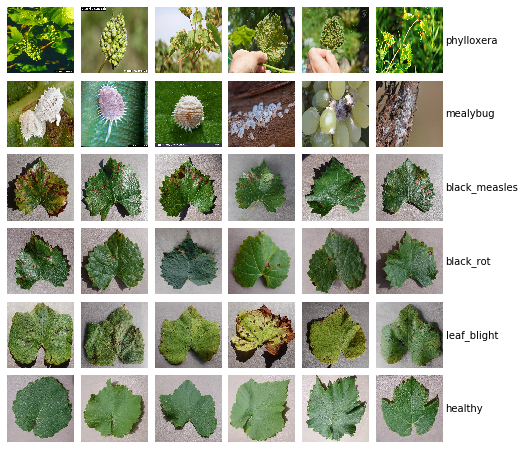

In [7]:
CATE = ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATE = len(CATE)
img_height, img_width = 256, 256

# Create image grid
figure = plt.figure(num=1, figsize=(8,8))
grid = ImageGrid(figure, 111, nrows_ncols=(NUM_CATE,NUM_CATE),
                 axes_pad=0.1) 

# Plot each image into a square
i = 0
for cate in CATE:
  for j in range(6):
    ax = grid[i]
    path = os.path.join(data, cate)
    pic = cate + str(j) + '.jpg'
    im = read_data(os.path.join(path, pic), size=(img_height, img_width))
    ax.imshow(im/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATE == NUM_CATE - 1:
      ax.text(x=img_height*1.05, y=img_height//2, s=cate, verticalalignment='center')
    i += 1

figure.show();

## Load images into numpy arrays

In [11]:
# Read all phylloxera images into numpy array
phylloxera_numpy = [read_data(os.path.join(train_phylloxera, img),\
               (256, 256)) for img in os.listdir(train_phylloxera)]

# Read all mealybug images into numpy array
mealybug_numpy = [read_data(os.path.join(train_mealybug, img),\
               (256, 256)) for img in os.listdir(train_mealybug)]


# Read all black measles images into numpy array
b_measles_numpy = [read_data(os.path.join(train_b_measles, img), \
                    (256, 256)) for img in os.listdir(train_b_measles)]

# Read all black rot images into numpy array
b_rot_numpy = [read_data(os.path.join(train_b_rot, img), \
                 (256, 256)) for img in os.listdir(train_b_rot)]

# Read all leaf blight images into numpy array
leaf_blight_numpy = [read_data(os.path.join(train_leaf_blight, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight)]

# Read all healthy images into numpy array
healthy_numpy = [read_data(os.path.join(train_healthy, img),\
               (256, 256)) for img in os.listdir(train_healthy)]


# Save numpy arrays into a folder
np.save(os.path.join(bin_data, 'phylloxera.npy'), arr=phylloxera_numpy)
np.save(os.path.join(bin_data, 'mealybug.npy'), arr=mealybug_numpy)
np.save(os.path.join(bin_data, 'black_measles.npy'), arr=b_measles_numpy)
np.save(os.path.join(bin_data, 'black_rot.npy'), arr=b_rot_numpy)
np.save(os.path.join(bin_data, 'leaf_blight.npy'), arr=leaf_blight_numpy)
np.save(os.path.join(bin_data, 'healthy.npy'), arr=healthy_numpy)


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [12]:
# Load numpy arrays from the folder
phylloxera_numpy = np.load(os.path.join(bin_data, 'phylloxera.npy'))
mealybug_numpy = np.load(os.path.join(bin_data, 'mealybug.npy'))
b_measles_numpy = np.load(os.path.join(bin_data, 'black_measles.npy'))
b_rot_numpy = np.load(os.path.join(bin_data, 'black_rot.npy'))
leaf_blight_numpy = np.load(os.path.join(bin_data, 'leaf_blight.npy'))
healthy_numpy = np.load(os.path.join(bin_data, 'healthy.npy'))

In [13]:
# Reshape numpy arrays into sizes of 256x256x3 as input data
phylloxera_numpy = phylloxera_numpy.reshape(128, 256*256*3)
mealybug_numpy = mealybug_numpy.reshape(343, 256*256*3)
b_measles_numpy = b_measles_numpy.reshape(886, 256*256*3)
b_rot_numpy = b_rot_numpy.reshape(756, 256*256*3)
leaf_blight_numpy = leaf_blight_numpy.reshape(689, 256*256*3)
healthy_numpy = healthy_numpy.reshape(272, 256*256*3)

### Visualize data

In [10]:
def pca(X=np.array([]), num_dimensions=60):
  """
  Runs PCA on an array X to reduce its dimensonality to 
  num_dimensions dimensions.
  
  """
  print('Running PCA ...')
  mean_vector = np.mean(a=X, axis=0)
  X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
  eig_vals, eig_vectors = np.linalg.eig(X_cov.T)
  idx = np.argsort(np.abs(eig_vals))[::-1]
  eig_vectors = eig_vectors[:, idx]
  Y = np.dot(X, eig_vectors[:, 0:num_dimensions])
  return Y

def plot_scatter(x, class_name):
  """
  Function to create a scatter plot for visualization of data
  along with respective colors/labels.
 
  """
  no_class = len(np.unique(class_name))
  color_palette = np.array(sns.color_palette('Set2', no_class))
  f = plt.figure(figsize=(15,15))
  ax = plt.subplot(aspect='equal')
  for i, pic_label in enumerate(np.unique(class_name)):
    idx = np.where(class_name == pic_label)
    ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=pic_label)
  ax.legend(loc='best', fontsize='medium')
  ax.axis('off')
  ax.axis('tight')
  plt.title('Visualization of grape diseases and pests in 2D')

In [15]:
# Create data labels for all classes in 1D
phylloxera_label = np.full(phylloxera_numpy.shape[0], 'phylloxera')
mealybug_label = np.full(mealybug_numpy.shape[0], 'mealybug')
b_measles_label = np.full(b_measles_numpy.shape[0], 'black_measles')
b_rot_label = np.full(b_rot_numpy.shape[0], 'black_rot')
leaf_blight_label = np.full(leaf_blight_numpy.shape[0], 'leaf_blight')
healthy_label = np.full(healthy_numpy.shape[0], 'healthy')

labels = (phylloxera_label, mealybug_label, b_measles_label, b_rot_label, leaf_blight_label, healthy_label)
labels = np.hstack(labels) 

In [17]:
# Create a stack of numpy arrays 
tuple_data = (phylloxera_numpy, mealybug_numpy, b_measles_numpy, b_rot_numpy, leaf_blight_numpy, healthy_numpy)

# normalize tuple data
nomalized_data = np.vstack(tup=tuple_data)/255. 

In [19]:
# Run PCA on nomalized data
start_time = time.time()
pca = PCA(n_components=60)
nomalized_data_pca = pca.fit_transform(nomalized_data)
end_time = time.time()

print('This process took {:.2f} seconds.'.format(end_time-start_time))

This process took 113.86 seconds.


In [21]:
# Run t-SNE on data
start_time = time.time()
tsne = TSNE(n_components=2)
nomalized_data_tsne = tsne.fit_transform(nomalized_data_pca)
end_time = time.time()

print('This process took {:.2f} seconds'.format(end_time-start_time))

This process took 50.40 seconds


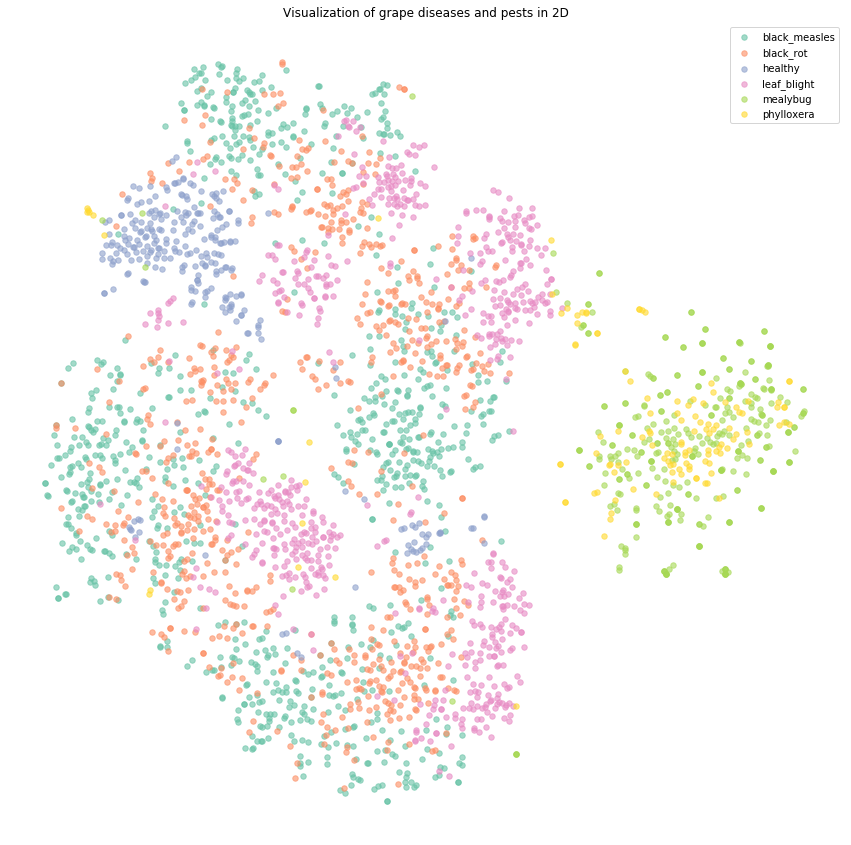

In [25]:
# Visualize data
plot_scatter(nomalized_data_tsne, labels);

## Training data

### Libraries

In [9]:
def draw_acc_loss(points, factor=0.9):
  
  drawed_points = []
  for point in points:
    if drawed_points:
      prev = drawed_points[-1]
      drawed_points.append(prev * factor + point * (1 - factor))
    else:
      drawed_points.append(point)
  return drawed_points

def plot_data(history_data, smooth=False):

  accuracy = history.history['acc']
  validation_acc = history.history['val_acc']
  loss = history.history['loss']
  validation_loss = history.history['val_loss']

  epochs = range(1, len(accuracy)+1)
  
  if smooth == True:
    accuracy = draw_acc_loss(accuracy)
    validation_acc = draw_acc_loss(validation_acc)
    loss = draw_acc_loss(loss)
    validation_loss = draw_acc_loss(validation_loss)

  plt.plot(epochs, accuracy, 'g', label='Training accuracy')
  plt.plot(epochs, validation_acc,'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'g', label='Training loss')
  plt.plot(epochs, validation_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def collect_metrics(model, generator, steps, class_names=[]):
  """
  Print out confusion matrix and classification report.
  """
  class_names = ['black_measles', 'black_rot', 'healthy', 'leaf_blight', 'mealybug', 'phylloxera']
  abbr = ['BM', 'BR', 'H', 'LB', 'M', 'P']
  
  # Generate predictions 
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Generate confusion matrix
  con_matrix = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(con_matrix, ax=ax, cmap=plt.cm.YlOrRd, annot=True, fmt='g')
  ax.set_xticklabels(abbr)
  ax.set_yticklabels(abbr)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('Real Class')
  plt.show()
  
  # Generate classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=class_names))

### Set up hyper-parameters

In [8]:
image_height, image_width = 256, 256
batch_size = 30
epochs = 35

print('Total number of training data:', total_train)
print('Total number of validation data:', total_valid)
print('Total number of test data:', total_test)

Total number of training data: 3074
Total number of validation data: 765
Total number of test data: 957


### Training from Scratch

In [22]:
model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                  input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [23]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

Training data using Keras ImageDataGenerator. Refer to the source on the website: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [13]:
# Rescale data
training_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

training_gen = training_datagenerator.flow_from_directory(
                    train_fold,
                    target_size=(image_height, image_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=30)

valid_gen = test_datagenerator.flow_from_directory(
                          val_fold,
                          target_size=(image_height, image_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

Found 3074 images belonging to 6 classes.
Found 765 images belonging to 6 classes.


In [13]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

# Define the Keras TensorBoard callback.
logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch=0)
    

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
#Scratch training
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 25 steps
Epoch 1/35
 47/102 [============>.................] - ETA: 3:04 - loss: 1.3609 - acc: 0.4570

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 329s 3s/step - loss: 0.9861 - acc: 0.6041 - val_loss: 0.5017 - val_acc: 0.8093
Epoch 2/35
 58/102 [================>.............] - ETA: 2:00 - loss: 0.3825 - acc: 0.8451

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 0.3608 - acc: 0.8581 - val_loss: 0.2877 - val_acc: 0.8933
Epoch 3/35
 50/102 [=============>................] - ETA: 2:20 - loss: 0.2528 - acc: 0.9003

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 297s 3s/step - loss: 0.2293 - acc: 0.9116 - val_loss: 0.2857 - val_acc: 0.9160
Epoch 4/35
 23/102 [=====>........................] - ETA: 3:49 - loss: 0.3331 - acc: 0.8725

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 314s 3s/step - loss: 0.2187 - acc: 0.9182 - val_loss: 0.2300 - val_acc: 0.9187
Epoch 5/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 304s 3s/step - loss: 0.1307 - acc: 0.9527 - val_loss: 0.2003 - val_acc: 0.9507
Epoch 6/35
 37/102 [=========>....................] - ETA: 3:00 - loss: 0.0842 - acc: 0.9730

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 0.0731 - acc: 0.9714 - val_loss: 0.1515 - val_acc: 0.9600
Epoch 7/35
 20/102 [====>.........................] - ETA: 3:44 - loss: 0.0349 - acc: 0.9850

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 0.0863 - acc: 0.9724 - val_loss: 0.1406 - val_acc: 0.9573
Epoch 8/35
 84/102 [=======================>......] - ETA: 49s - loss: 0.0386 - acc: 0.9893

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 0.0377 - acc: 0.9898 - val_loss: 0.1518 - val_acc: 0.9533
Epoch 9/35
 85/102 [========================>.....] - ETA: 45s - loss: 0.0261 - acc: 0.9917

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 295s 3s/step - loss: 0.0251 - acc: 0.9924 - val_loss: 0.1756 - val_acc: 0.9627
Epoch 10/35
 52/102 [==============>...............] - ETA: 2:22 - loss: 0.0162 - acc: 0.9949

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 311s 3s/step - loss: 0.0257 - acc: 0.9918 - val_loss: 0.1335 - val_acc: 0.9613
Epoch 11/35
 86/102 [========================>.....] - ETA: 44s - loss: 0.0443 - acc: 0.9863

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 309s 3s/step - loss: 0.0439 - acc: 0.9859 - val_loss: 0.1632 - val_acc: 0.9640
Epoch 12/35
 13/102 [==>...........................] - ETA: 4:11 - loss: 0.0575 - acc: 0.9872

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 311s 3s/step - loss: 0.0381 - acc: 0.9869 - val_loss: 0.1249 - val_acc: 0.9600
Epoch 13/35
 88/102 [========================>.....] - ETA: 37s - loss: 0.0562 - acc: 0.9836

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 299s 3s/step - loss: 0.0644 - acc: 0.9816 - val_loss: 0.1364 - val_acc: 0.9613
Epoch 14/35
 84/102 [=======================>......] - ETA: 49s - loss: 0.0428 - acc: 0.9877

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 300s 3s/step - loss: 0.0567 - acc: 0.9826 - val_loss: 0.2809 - val_acc: 0.9160
Epoch 15/35
 14/102 [===>..........................] - ETA: 3:53 - loss: 0.0561 - acc: 0.9802

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 0.0296 - acc: 0.9892 - val_loss: 0.0944 - val_acc: 0.9773
Epoch 16/35
 65/102 [==================>...........] - ETA: 1:43 - loss: 0.0091 - acc: 0.9969

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 305s 3s/step - loss: 0.0062 - acc: 0.9980 - val_loss: 0.1390 - val_acc: 0.9747
Epoch 17/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 300s 3s/step - loss: 4.7594e-04 - acc: 1.0000 - val_loss: 0.1464 - val_acc: 0.9747
Epoch 18/35
 87/102 [========================>.....] - ETA: 41s - loss: 1.5807e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 306s 3s/step - loss: 1.5262e-04 - acc: 1.0000 - val_loss: 0.1473 - val_acc: 0.9747
Epoch 19/35
 25/102 [======>.......................] - ETA: 3:23 - loss: 1.3216e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 298s 3s/step - loss: 1.0322e-04 - acc: 1.0000 - val_loss: 0.1462 - val_acc: 0.9747
Epoch 20/35
  6/102 [>.............................] - ETA: 4:26 - loss: 8.8098e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 305s 3s/step - loss: 8.1580e-05 - acc: 1.0000 - val_loss: 0.1529 - val_acc: 0.9747
Epoch 21/35
 78/102 [=====================>........] - ETA: 1:05 - loss: 7.2500e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 299s 3s/step - loss: 6.4587e-05 - acc: 1.0000 - val_loss: 0.1556 - val_acc: 0.9760
Epoch 22/35
 87/102 [========================>.....] - ETA: 41s - loss: 4.6612e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 301s 3s/step - loss: 5.2518e-05 - acc: 1.0000 - val_loss: 0.1623 - val_acc: 0.9760
Epoch 23/35
 78/102 [=====================>........] - ETA: 1:08 - loss: 4.4120e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 312s 3s/step - loss: 4.1995e-05 - acc: 1.0000 - val_loss: 0.1612 - val_acc: 0.9760
Epoch 24/35
 74/102 [====================>.........] - ETA: 1:16 - loss: 3.4177e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 3.6304e-05 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 0.9760
Epoch 25/35
 79/102 [======================>.......] - ETA: 1:02 - loss: 2.9725e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 300s 3s/step - loss: 2.8386e-05 - acc: 1.0000 - val_loss: 0.1680 - val_acc: 0.9760
Epoch 26/35
 48/102 [=============>................] - ETA: 2:24 - loss: 1.7674e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 299s 3s/step - loss: 2.5029e-05 - acc: 1.0000 - val_loss: 0.1658 - val_acc: 0.9747
Epoch 27/35
 91/102 [=========================>....] - ETA: 30s - loss: 2.1073e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 305s 3s/step - loss: 1.9977e-05 - acc: 1.0000 - val_loss: 0.1711 - val_acc: 0.9760
Epoch 28/35
 71/102 [===================>..........] - ETA: 1:24 - loss: 1.8256e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 303s 3s/step - loss: 1.7505e-05 - acc: 1.0000 - val_loss: 0.1745 - val_acc: 0.9760
Epoch 29/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 309s 3s/step - loss: 1.5025e-05 - acc: 1.0000 - val_loss: 0.1750 - val_acc: 0.9747
Epoch 30/35
 79/102 [======================>.......] - ETA: 1:04 - loss: 1.3682e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 308s 3s/step - loss: 1.2918e-05 - acc: 1.0000 - val_loss: 0.1719 - val_acc: 0.9747
Epoch 31/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 307s 3s/step - loss: 1.1492e-05 - acc: 1.0000 - val_loss: 0.1729 - val_acc: 0.9747
Epoch 32/35
 89/102 [=========================>....] - ETA: 37s - loss: 1.0149e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 317s 3s/step - loss: 1.0205e-05 - acc: 1.0000 - val_loss: 0.1759 - val_acc: 0.9747
Epoch 33/35
 80/102 [======================>.......] - ETA: 1:03 - loss: 8.8262e-06 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 318s 3s/step - loss: 9.0503e-06 - acc: 1.0000 - val_loss: 0.1745 - val_acc: 0.9747
Epoch 34/35
 60/102 [================>.............] - ETA: 1:59 - loss: 8.0426e-06 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 312s 3s/step - loss: 8.1389e-06 - acc: 1.0000 - val_loss: 0.1798 - val_acc: 0.9747
Epoch 35/35
 36/102 [=========>....................] - ETA: 3:09 - loss: 6.4989e-06 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 319s 3s/step - loss: 7.1476e-06 - acc: 1.0000 - val_loss: 0.1811 - val_acc: 0.9747


In [50]:
# Save the trained model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-scratch.h5'))

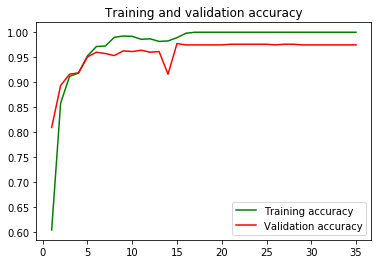

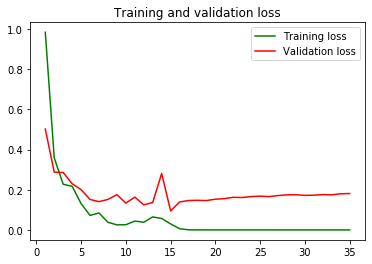

In [36]:
plot_data(history)

In [31]:
# Create a new validation generator for evaluation
valid_test_gen = test_datagenerator.flow_from_directory(
                val_fold,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 765 images belonging to 6 classes.


In [32]:
# Observe all 6 classes
valid_test_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Format of confusion matrix:

|  | Prediction |  |  |  |  |
| - | - | - | - | - | - |
| **True** | black_measles | black_rot | healthy | leaf_blight | mealybug | phylloxera | 
| black_measles | 
| black_rot | 
| healthy | 
| leaf_blight |
| mealybug |
| phylloxera | 

Instructions for updating:
Please use Model.predict, which supports generators.


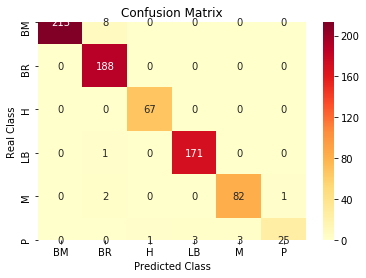

Classification Report
               precision    recall  f1-score   support

black_measles       1.00      0.96      0.98       221
    black_rot       0.94      1.00      0.97       188
      healthy       0.99      1.00      0.99        67
  leaf_blight       0.98      0.99      0.99       172
     mealybug       0.96      0.96      0.96        85
   phylloxera       0.96      0.78      0.86        32

     accuracy                           0.98       765
    macro avg       0.97      0.95      0.96       765
 weighted avg       0.98      0.98      0.97       765



In [33]:
# Load the trained model from the folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-scratch.h5'))

# Display confusion matrix and classification report
collect_metrics(model, generator=valid_test_gen, steps=total_valid)

### Transfer Learning

In [12]:
# Import VGG16
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(image_height, image_width, 3))

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
# Add more layers into the original VGG16 model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 23,105,094
Trainable params: 23,105,094
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Freeze convolutional base
print('Trainable weights before freezing:', len(model.trainable_weights))
conv_base.trainable = False
print('Trainable weights after freezing:', len(model.trainable_weights))

Trainable weights before freezing: 30
Trainable weights after freezing: 4


In [16]:
# Generate training data using data augmentation
training_datageneration = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=45,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# Rescale validation data
test_datageneration = ImageDataGenerator(rescale=1./255)

training_gen = training_datageneration.flow_from_directory(
                    train_fold,
                    target_size=(image_height, image_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=50)

valid_gen = test_datageneration.flow_from_directory(
                          val_fold,
                          target_size=(image_height, image_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

Found 3074 images belonging to 6 classes.
Found 765 images belonging to 6 classes.


In [31]:
# Train VGG16 model
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 25 steps
Epoch 1/35
 59/102 [================>.............] - ETA: 5:19 - loss: 1.4981 - acc: 0.6123

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 954s 9s/step - loss: 1.0862 - acc: 0.6968 - val_loss: 0.2938 - val_acc: 0.9067
Epoch 2/35
 81/102 [======================>.......] - ETA: 2:39 - loss: 0.4160 - acc: 0.8372

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 964s 9s/step - loss: 0.4114 - acc: 0.8377 - val_loss: 0.2224 - val_acc: 0.9227
Epoch 3/35
 22/102 [=====>........................] - ETA: 10:16 - loss: 0.3698 - acc: 0.8515

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 963s 9s/step - loss: 0.3756 - acc: 0.8492 - val_loss: 0.2311 - val_acc: 0.9067
Epoch 4/35
 75/102 [=====================>........] - ETA: 3:49 - loss: 0.3518 - acc: 0.8591

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1102s 11s/step - loss: 0.3589 - acc: 0.8538 - val_loss: 0.2055 - val_acc: 0.9253
Epoch 5/35
  5/102 [>.............................] - ETA: 14:35 - loss: 0.4302 - acc: 0.8667

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1140s 11s/step - loss: 0.3652 - acc: 0.8610 - val_loss: 0.1726 - val_acc: 0.9373
Epoch 6/35
 62/102 [=================>............] - ETA: 5:31 - loss: 0.3586 - acc: 0.8492

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1035s 10s/step - loss: 0.3654 - acc: 0.8518 - val_loss: 0.1823 - val_acc: 0.9280
Epoch 7/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 980s 10s/step - loss: 0.3340 - acc: 0.8637 - val_loss: 0.1610 - val_acc: 0.9387
Epoch 8/35
 65/102 [==================>...........] - ETA: 4:42 - loss: 0.3106 - acc: 0.8749

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 958s 9s/step - loss: 0.3044 - acc: 0.8781 - val_loss: 0.1386 - val_acc: 0.9533
Epoch 9/35
 54/102 [==============>...............] - ETA: 6:06 - loss: 0.3142 - acc: 0.8722

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 966s 9s/step - loss: 0.3092 - acc: 0.8735 - val_loss: 0.1771 - val_acc: 0.9253
Epoch 10/35
 68/102 [===================>..........] - ETA: 4:22 - loss: 0.2882 - acc: 0.8858

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 969s 9s/step - loss: 0.2909 - acc: 0.8847 - val_loss: 0.1498 - val_acc: 0.9453
Epoch 11/35
 76/102 [=====================>........] - ETA: 3:15 - loss: 0.2732 - acc: 0.8936

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 956s 9s/step - loss: 0.2658 - acc: 0.8955 - val_loss: 0.1304 - val_acc: 0.9493
Epoch 12/35
 27/102 [======>.......................] - ETA: 9:30 - loss: 0.2529 - acc: 0.8926

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 956s 9s/step - loss: 0.2632 - acc: 0.8939 - val_loss: 0.1148 - val_acc: 0.9573
Epoch 13/35
 13/102 [==>...........................] - ETA: 11:32 - loss: 0.3227 - acc: 0.8692

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 938s 9s/step - loss: 0.2757 - acc: 0.8853 - val_loss: 0.1406 - val_acc: 0.9413
Epoch 14/35
 65/102 [==================>...........] - ETA: 4:31 - loss: 0.2872 - acc: 0.8909

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 933s 9s/step - loss: 0.2828 - acc: 0.8939 - val_loss: 0.1106 - val_acc: 0.9653
Epoch 15/35
 51/102 [==============>...............] - ETA: 6:14 - loss: 0.3037 - acc: 0.8712

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 948s 9s/step - loss: 0.2716 - acc: 0.8929 - val_loss: 0.1068 - val_acc: 0.9600
Epoch 16/35
 62/102 [=================>............] - ETA: 4:58 - loss: 0.2398 - acc: 0.9065

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 942s 9s/step - loss: 0.2377 - acc: 0.9093 - val_loss: 0.1073 - val_acc: 0.9640
Epoch 17/35
 43/102 [===========>..................] - ETA: 7:24 - loss: 0.2702 - acc: 0.8876

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 948s 9s/step - loss: 0.2450 - acc: 0.9024 - val_loss: 0.1012 - val_acc: 0.9587
Epoch 18/35
 45/102 [============>.................] - ETA: 7:14 - loss: 0.2430 - acc: 0.9022

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 949s 9s/step - loss: 0.2508 - acc: 0.9044 - val_loss: 0.1047 - val_acc: 0.9613
Epoch 19/35
 84/102 [=======================>......] - ETA: 2:13 - loss: 0.2410 - acc: 0.9077

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 937s 9s/step - loss: 0.2422 - acc: 0.9074 - val_loss: 0.1037 - val_acc: 0.9627
Epoch 20/35
 58/102 [================>.............] - ETA: 5:27 - loss: 0.2570 - acc: 0.9089

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 946s 9s/step - loss: 0.2609 - acc: 0.9044 - val_loss: 0.1241 - val_acc: 0.9600
Epoch 21/35
 50/102 [=============>................] - ETA: 6:29 - loss: 0.2596 - acc: 0.8848

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 945s 9s/step - loss: 0.2480 - acc: 0.8991 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 22/35
 74/102 [====================>.........] - ETA: 3:29 - loss: 0.2770 - acc: 0.9047

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 945s 9s/step - loss: 0.2617 - acc: 0.9103 - val_loss: 0.1147 - val_acc: 0.9573
Epoch 23/35
 54/102 [==============>...............] - ETA: 6:04 - loss: 0.2689 - acc: 0.9037

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 963s 9s/step - loss: 0.2631 - acc: 0.9044 - val_loss: 0.1154 - val_acc: 0.9627
Epoch 24/35
 22/102 [=====>........................] - ETA: 10:15 - loss: 0.2403 - acc: 0.9015

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 984s 10s/step - loss: 0.2478 - acc: 0.9074 - val_loss: 0.0921 - val_acc: 0.9667
Epoch 25/35
 79/102 [======================>.......] - ETA: 2:55 - loss: 0.2500 - acc: 0.9027

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1000s 10s/step - loss: 0.2478 - acc: 0.9021 - val_loss: 0.1067 - val_acc: 0.9613
Epoch 26/35
 67/102 [==================>...........] - ETA: 4:32 - loss: 0.2806 - acc: 0.8877

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 985s 10s/step - loss: 0.2774 - acc: 0.8883 - val_loss: 0.2507 - val_acc: 0.8787
Epoch 27/35
  3/102 [..............................] - ETA: 13:16 - loss: 0.3517 - acc: 0.8556

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1000s 10s/step - loss: 0.2640 - acc: 0.8975 - val_loss: 0.1271 - val_acc: 0.9347
Epoch 28/35
 25/102 [======>.......................] - ETA: 10:02 - loss: 0.3464 - acc: 0.8747

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 968s 9s/step - loss: 0.2663 - acc: 0.8998 - val_loss: 0.0901 - val_acc: 0.9693
Epoch 29/35
 14/102 [===>..........................] - ETA: 10:58 - loss: 0.1867 - acc: 0.9333

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 939s 9s/step - loss: 0.2361 - acc: 0.9087 - val_loss: 0.0748 - val_acc: 0.9773
Epoch 30/35
  4/102 [>.............................] - ETA: 12:46 - loss: 0.1386 - acc: 0.9500

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 990s 10s/step - loss: 0.2493 - acc: 0.8991 - val_loss: 0.0955 - val_acc: 0.9680
Epoch 31/35
 67/102 [==================>...........] - ETA: 4:49 - loss: 0.2628 - acc: 0.8975

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1127s 11s/step - loss: 0.2637 - acc: 0.8982 - val_loss: 0.0894 - val_acc: 0.9747
Epoch 32/35
 27/102 [======>.......................] - ETA: 10:50 - loss: 0.1824 - acc: 0.9383

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1085s 11s/step - loss: 0.2178 - acc: 0.9162 - val_loss: 0.1292 - val_acc: 0.9453
Epoch 33/35
 85/102 [========================>.....] - ETA: 2:08 - loss: 0.2483 - acc: 0.9152

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 963s 9s/step - loss: 0.2400 - acc: 0.9175 - val_loss: 0.0958 - val_acc: 0.9653
Epoch 34/35
 73/102 [====================>.........] - ETA: 3:42 - loss: 0.2087 - acc: 0.9209

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 972s 10s/step - loss: 0.2122 - acc: 0.9189 - val_loss: 0.0910 - val_acc: 0.9653
Epoch 35/35
 76/102 [=====================>........] - ETA: 3:21 - loss: 0.2141 - acc: 0.9197

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 968s 9s/step - loss: 0.2101 - acc: 0.9195 - val_loss: 0.0823 - val_acc: 0.9747


In [32]:
# Save the trained model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-VGG16.h5'))

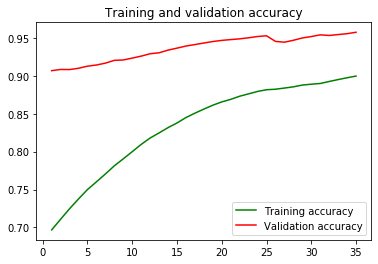

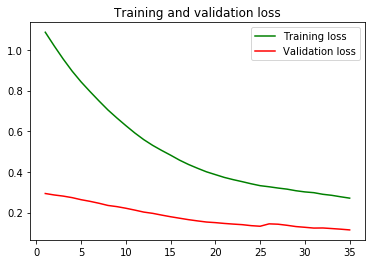

In [33]:
plot_data(history, smooth=True)

In [15]:
# Create a new validation generator for evaluation
valid_test_gen = test_datageneration.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 765 images belonging to 6 classes.


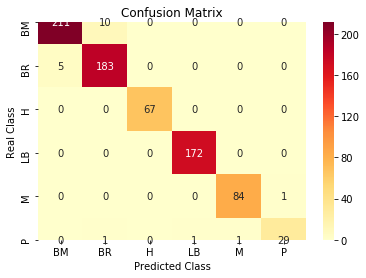

Classification Report
               precision    recall  f1-score   support

black_measles       0.98      0.95      0.97       221
    black_rot       0.94      0.97      0.96       188
      healthy       1.00      1.00      1.00        67
  leaf_blight       0.99      1.00      1.00       172
     mealybug       0.99      0.99      0.99        85
   phylloxera       0.97      0.91      0.94        32

     accuracy                           0.98       765
    macro avg       0.98      0.97      0.97       765
 weighted avg       0.98      0.98      0.98       765



In [35]:
# Load the trained model from the folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16.h5'))

# Display confusion matrix and classification report
collect_metrics(model, generator=valid_test_gen, steps=total_valid)

### Fine-Tune Model

In [36]:
conv_base.layers

In [37]:
# Get the final convolutional block
conv_base.layers[0].name

'input_2'

In [38]:
# Fine-tune the model by unfreezing the final convolutional block

conv_base.trainable = True
trainable_logic = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    trainable_logic = True
  if trainable_logic:
    layer.trainable = True
  else:
    layer.trainable = False

In [39]:
# Compile the model and avoid overfitting by utilizing a much smaller learning rate
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [40]:
# Train the model
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 102 steps, validate for 25 steps
Epoch 1/35
 89/102 [=========================>....] - ETA: 1:36 - loss: 0.2011 - acc: 0.9231

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 947s 9s/step - loss: 0.1970 - acc: 0.9238 - val_loss: 0.0721 - val_acc: 0.9760
Epoch 2/35
  1/102 [..............................] - ETA: 13:58 - loss: 0.2495 - acc: 0.9000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 962s 9s/step - loss: 0.1889 - acc: 0.9258 - val_loss: 0.0737 - val_acc: 0.9760
Epoch 3/35
  1/102 [..............................] - ETA: 14:13 - loss: 0.0826 - acc: 0.9667

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 951s 9s/step - loss: 0.1946 - acc: 0.9307 - val_loss: 0.0757 - val_acc: 0.9760
Epoch 4/35
 12/102 [==>...........................] - ETA: 11:23 - loss: 0.2080 - acc: 0.9306

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 959s 9s/step - loss: 0.1896 - acc: 0.9310 - val_loss: 0.0763 - val_acc: 0.9747
Epoch 5/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 960s 9s/step - loss: 0.1713 - acc: 0.9382 - val_loss: 0.0765 - val_acc: 0.9760
Epoch 6/35
 10/102 [=>............................] - ETA: 11:39 - loss: 0.1424 - acc: 0.9467

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 38840s 381s/step - loss: 0.1655 - acc: 0.9399 - val_loss: 0.0758 - val_acc: 0.9760
Epoch 7/35
  2/102 [..............................] - ETA: 18:12 - loss: 0.1593 - acc: 0.9500

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1060s 10s/step - loss: 0.1717 - acc: 0.9369 - val_loss: 0.0754 - val_acc: 0.9773
Epoch 8/35
 45/102 [============>.................] - ETA: 8:09 - loss: 0.1631 - acc: 0.9408

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1038s 10s/step - loss: 0.1698 - acc: 0.9359 - val_loss: 0.0738 - val_acc: 0.9787
Epoch 9/35
 28/102 [=======>......................] - ETA: 9:32 - loss: 0.1826 - acc: 0.9429

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1001s 10s/step - loss: 0.1754 - acc: 0.9389 - val_loss: 0.0744 - val_acc: 0.9800
Epoch 10/35
 67/102 [==================>...........] - ETA: 4:29 - loss: 0.1582 - acc: 0.9413

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 978s 10s/step - loss: 0.1595 - acc: 0.9402 - val_loss: 0.0737 - val_acc: 0.9773
Epoch 11/35
 76/102 [=====================>........] - ETA: 3:36 - loss: 0.1538 - acc: 0.9457

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1069s 10s/step - loss: 0.1581 - acc: 0.9448 - val_loss: 0.0729 - val_acc: 0.9813
Epoch 12/35
  7/102 [=>............................] - ETA: 12:30 - loss: 0.1359 - acc: 0.9429

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1001s 10s/step - loss: 0.1532 - acc: 0.9451 - val_loss: 0.0720 - val_acc: 0.9760
Epoch 13/35
 91/102 [=========================>....] - ETA: 1:24 - loss: 0.1682 - acc: 0.9340

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 971s 10s/step - loss: 0.1726 - acc: 0.9330 - val_loss: 0.0716 - val_acc: 0.9800
Epoch 14/35
 81/102 [======================>.......] - ETA: 2:38 - loss: 0.1535 - acc: 0.9428

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 951s 9s/step - loss: 0.1528 - acc: 0.9402 - val_loss: 0.0716 - val_acc: 0.9800
Epoch 15/35
  2/102 [..............................] - ETA: 13:46 - loss: 0.2705 - acc: 0.9167

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 946s 9s/step - loss: 0.1516 - acc: 0.9396 - val_loss: 0.0718 - val_acc: 0.9760
Epoch 16/35
 57/102 [===============>..............] - ETA: 5:35 - loss: 0.1426 - acc: 0.9457

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 944s 9s/step - loss: 0.1563 - acc: 0.9419 - val_loss: 0.0713 - val_acc: 0.9787
Epoch 17/35
 12/102 [==>...........................] - ETA: 11:24 - loss: 0.1891 - acc: 0.9250

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 944s 9s/step - loss: 0.1498 - acc: 0.9412 - val_loss: 0.0709 - val_acc: 0.9773
Epoch 18/35
 41/102 [===========>..................] - ETA: 7:36 - loss: 0.1571 - acc: 0.9382

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 957s 9s/step - loss: 0.1548 - acc: 0.9366 - val_loss: 0.0716 - val_acc: 0.9747
Epoch 19/35
 33/102 [========>.....................] - ETA: 9:00 - loss: 0.1656 - acc: 0.9312

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1097s 11s/step - loss: 0.1555 - acc: 0.9386 - val_loss: 0.0719 - val_acc: 0.9773
Epoch 20/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1117s 11s/step - loss: 0.1688 - acc: 0.9313 - val_loss: 0.0715 - val_acc: 0.9760
Epoch 21/35
 58/102 [================>.............] - ETA: 6:25 - loss: 0.1750 - acc: 0.9351

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1029s 10s/step - loss: 0.1570 - acc: 0.9402 - val_loss: 0.0720 - val_acc: 0.9773
Epoch 22/35
 29/102 [=======>......................] - ETA: 9:18 - loss: 0.1556 - acc: 0.9391

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1012s 10s/step - loss: 0.1630 - acc: 0.9382 - val_loss: 0.0719 - val_acc: 0.9800
Epoch 23/35
 92/102 [==========================>...] - ETA: 1:20 - loss: 0.1487 - acc: 0.9421

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1024s 10s/step - loss: 0.1465 - acc: 0.9425 - val_loss: 0.0723 - val_acc: 0.9787
Epoch 24/35
 42/102 [===========>..................] - ETA: 7:44 - loss: 0.1607 - acc: 0.9365

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 984s 10s/step - loss: 0.1526 - acc: 0.9396 - val_loss: 0.0714 - val_acc: 0.9787
Epoch 25/35
 33/102 [========>.....................] - ETA: 9:00 - loss: 0.1535 - acc: 0.9374

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 999s 10s/step - loss: 0.1505 - acc: 0.9389 - val_loss: 0.0706 - val_acc: 0.9787
Epoch 26/35
 33/102 [========>.....................] - ETA: 8:46 - loss: 0.1467 - acc: 0.9466

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 987s 10s/step - loss: 0.1462 - acc: 0.9458 - val_loss: 0.0698 - val_acc: 0.9787
Epoch 27/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 998s 10s/step - loss: 0.1489 - acc: 0.9422 - val_loss: 0.0701 - val_acc: 0.9787
Epoch 28/35
 63/102 [=================>............] - ETA: 4:59 - loss: 0.1521 - acc: 0.9434

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 987s 10s/step - loss: 0.1493 - acc: 0.9422 - val_loss: 0.0700 - val_acc: 0.9787
Epoch 29/35
 85/102 [========================>.....] - ETA: 2:14 - loss: 0.1338 - acc: 0.9507

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1002s 10s/step - loss: 0.1444 - acc: 0.9461 - val_loss: 0.0704 - val_acc: 0.9787
Epoch 30/35
 53/102 [==============>...............] - ETA: 6:17 - loss: 0.1503 - acc: 0.9459

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 964s 9s/step - loss: 0.1425 - acc: 0.9465 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 31/35
  8/102 [=>............................] - ETA: 13:25 - loss: 0.1376 - acc: 0.9375

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1020s 10s/step - loss: 0.1408 - acc: 0.9438 - val_loss: 0.0702 - val_acc: 0.9800
Epoch 32/35
 86/102 [========================>.....] - ETA: 2:08 - loss: 0.1355 - acc: 0.9501

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1018s 10s/step - loss: 0.1366 - acc: 0.9491 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 33/35
  5/102 [>.............................] - ETA: 12:56 - loss: 0.1020 - acc: 0.9600

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 994s 10s/step - loss: 0.1380 - acc: 0.9511 - val_loss: 0.0698 - val_acc: 0.9800
Epoch 34/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1033s 10s/step - loss: 0.1476 - acc: 0.9409 - val_loss: 0.0699 - val_acc: 0.9787
Epoch 35/35
 65/102 [==================>...........] - ETA: 5:00 - loss: 0.1309 - acc: 0.9529

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


102/102 [==============================] - 1036s 10s/step - loss: 0.1348 - acc: 0.9514 - val_loss: 0.0715 - val_acc: 0.9787


In [41]:
# Save the model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))

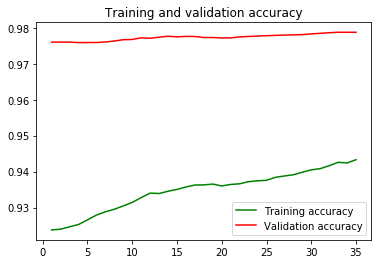

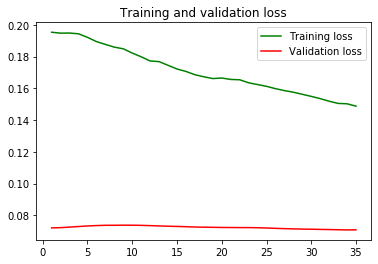

In [42]:
plot_data(history, smooth=True)

In [16]:
# Create a new validation generator for evaluation
val_test_gen = test_datageneration.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 765 images belonging to 6 classes.


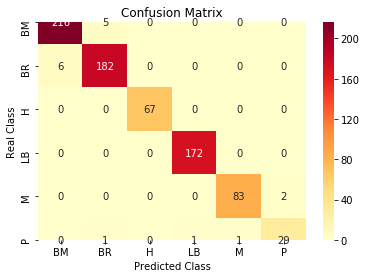

Classification Report
               precision    recall  f1-score   support

black_measles       0.97      0.98      0.98       221
    black_rot       0.97      0.97      0.97       188
      healthy       1.00      1.00      1.00        67
  leaf_blight       0.99      1.00      1.00       172
     mealybug       0.99      0.98      0.98        85
   phylloxera       0.94      0.91      0.92        32

     accuracy                           0.98       765
    macro avg       0.98      0.97      0.97       765
 weighted avg       0.98      0.98      0.98       765



In [44]:
# Load the saved model from the pre-defined folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))

# Display confusion matrix and classification report
collect_metrics(model, generator=val_test_gen, steps=total_valid)


### Final Model Evaluation on Test Data

In [17]:
# Create a new test generator for evaluation
test_generator = test_datageneration.flow_from_directory(
                test_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 957 images belonging to 6 classes.


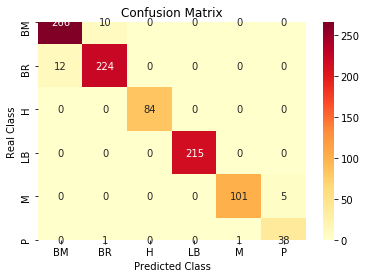

Classification Report
               precision    recall  f1-score   support

black_measles       0.96      0.96      0.96       276
    black_rot       0.95      0.95      0.95       236
      healthy       1.00      1.00      1.00        84
  leaf_blight       1.00      1.00      1.00       215
     mealybug       0.99      0.95      0.97       106
   phylloxera       0.88      0.95      0.92        40

     accuracy                           0.97       957
    macro avg       0.96      0.97      0.97       957
 weighted avg       0.97      0.97      0.97       957



In [31]:
# Load the saved model from the pre-defined folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))


# Display confusion matrix and classification report
collect_metrics(model, generator=test_generator, steps=total_test)

In [19]:
# Look for all misclassified images 
y_pred = model.predict_generator(generator=test_generator, steps=total_test)
y_pred = np.argmax(y_pred, axis=1)
y_real = test_generator.classes

# Show indices of these misclassified images
index = np.where(np.not_equal(y_pred, y_real))
index

(array([  4,  53,  74, 100, 211, 219, 238, 246, 248, 259, 321, 330, 358,
        361, 375, 400, 401, 406, 438, 455, 475, 510, 812, 853, 864, 895,
        914, 919, 921], dtype=int64),)

In [20]:
# Display paths of misclassified images
paths = [test_generator.filepaths[i] for i in index[0]]
paths

['.\\img_data\\test\\black_measles\\black_measles1022.jpg',
 '.\\img_data\\test\\black_measles\\black_measles1227.jpg',
 '.\\img_data\\test\\black_measles\\black_measles1323.jpg',
 '.\\img_data\\test\\black_measles\\black_measles213.jpg',
 '.\\img_data\\test\\black_measles\\black_measles689.jpg',
 '.\\img_data\\test\\black_measles\\black_measles753.jpg',
 '.\\img_data\\test\\black_measles\\black_measles86.jpg',
 '.\\img_data\\test\\black_measles\\black_measles883.jpg',
 '.\\img_data\\test\\black_measles\\black_measles897.jpg',
 '.\\img_data\\test\\black_measles\\black_measles945.jpg',
 '.\\img_data\\test\\black_rot\\black_rot123.jpg',
 '.\\img_data\\test\\black_rot\\black_rot193.jpg',
 '.\\img_data\\test\\black_rot\\black_rot341.jpg',
 '.\\img_data\\test\\black_rot\\black_rot356.jpg',
 '.\\img_data\\test\\black_rot\\black_rot41.jpg',
 '.\\img_data\\test\\black_rot\\black_rot525.jpg',
 '.\\img_data\\test\\black_rot\\black_rot526.jpg',
 '.\\img_data\\test\\black_rot\\black_rot550.jpg',
 

In [20]:
# Print all hidden layers
tf.compat.v1.disable_eager_execution()
for layer in model.layers:
    hidden_layer = layer.output
    
    print(hidden_layer)

Tensor("block5_pool_1/Identity:0", shape=(None, 8, 8, 512), dtype=float32)
Tensor("flatten_1/Identity:0", shape=(None, 32768), dtype=float32)
Tensor("dense_2/Identity:0", shape=(None, 256), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(None, 256), dtype=float32)
Tensor("dense_3/Identity:0", shape=(None, 6), dtype=float32)


In [24]:
# Display each layer information
from keras.models import Sequential
from keras import layers as l
from keras.applications.vgg16 import VGG16
from keras_sequential_ascii import keras2ascii

conv_base1 = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(img_height, img_width, 3))
keras2ascii(conv_base1)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    256  256    3
          InputLayer     |   -------------------         0     0.0%
                       #####    256  256    3
              Conv2D    \|/  -------------------      1792     0.0%
                relu   #####    256  256   64
              Conv2D    \|/  -------------------     36928     0.3%
                relu   #####    256  256   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####    128  128   64
              Conv2D    \|/  -------------------     73856     0.5%
                relu   #####    128  128  128
              Conv2D    \|/  -------------------    147584     1.0%
                relu   #####    128  128  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64   64  128
              Conv2D    \|/  -------------------    295168     2.0%
              

In [66]:
# Display each layer information
from keras.models import Sequential
from keras import layers as l
from keras.applications.vgg16 import VGG16
from keras_sequential_ascii import keras2ascii

vgg16 = VGG16(weights=None)
keras2ascii(vgg16)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    224  224    3
          InputLayer     |   -------------------         0     0.0%
                       #####    224  224    3
              Conv2D    \|/  -------------------      1792     0.0%
                relu   #####    224  224   64
              Conv2D    \|/  -------------------     36928     0.0%
                relu   #####    224  224   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####    112  112   64
              Conv2D    \|/  -------------------     73856     0.1%
                relu   #####    112  112  128
              Conv2D    \|/  -------------------    147584     0.1%
                relu   #####    112  112  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     56   56  128
              Conv2D    \|/  -------------------    295168     0.2%
              

In [86]:
# Extract weights and bias on each layer
for layer in model.layers:

    # Get layer name
    print("Layer name: ", layer.name, "\n")
    
    # Get layer configuration
    print("Layer configuration: ", layer.get_config(), "\n")
    
    # Get layer weights and bias
    w = layer.get_weights()
    if w != []:
        weights = layer.get_weights()[0]
        bias = layer.get_weights()[1]
        print("Layer weights: ", weights, "\n")
        print("Layer bias: ", bias, "\n")
    else:
        print("Layer weights and bias: ", w)

Layer name:  vgg16 

Layer configuration:  {'name': 'vgg16', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 256, 256, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'name': 'input_2', 'inbound_nodes': []}, {'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'block1_conv1', 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': False, 'dtype': 'float32', 'filters': 6

In [21]:
# get all nodes in each layer
for layer in model.layers:
    for node in layer._inbound_nodes:
         for i in range(len(node.inbound_layers)):
            inbound_node_index = node.node_indices
            layer.get_input_at(inbound_node_index)
            layer.get_output_at(inbound_node_index)
            layer.get_input_shape_at(inbound_node_index)
            layer.get_output_shape_at(inbound_node_index)

TypeError: object of type 'InputLayer' has no len()

In [22]:
all_nodes = [n for n in tf.get_default_graph().as_graph_def().node]
layer.get_input_at(node_index)
layer.get_output_at(node_index)
layer.get_input_shape_at(node_index)
layer.get_output_shape_at(node_index)

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [117]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))
    print('For batch {}, accuracy is {:7.2f}.'.format(batch, logs['accuracy']))

  def on_test_batch_end(self, batch, logs=None):
    print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))
    print('For batch {}, accuracy is {:7.2f}.'.format(batch, logs['accuracy']))

  def on_epoch_end(self, epoch, logs=None):
    print('The average loss for epoch {} is {:7.2f} and accuracy is {:7.2f}.'.format(epoch, logs['loss'], logs['accuracy']))
    

In [118]:
from tensorflow import keras
# Define the model.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

hist = model.fit(
    train_images,
    train_labels, 
    batch_size=64,
    epochs=5,
    callbacks=[LossAndErrorPrintingCallback()])

Train on 60000 samples
Epoch 1/5
For batch 0, loss is    2.42.
For batch 0, accuracy is    0.16.
   64/60000 [..............................] - ETA: 1:32 - loss: 2.4171 - accuracy: 0.1562For batch 1, loss is    2.24.
For batch 1, accuracy is    0.19.
For batch 2, loss is    2.32.
For batch 2, accuracy is    0.15.
For batch 3, loss is    2.26.
For batch 3, accuracy is    0.16.
For batch 4, loss is    2.22.
For batch 4, accuracy is    0.15.
For batch 5, loss is    2.11.
For batch 5, accuracy is    0.17.
For batch 6, loss is    2.14.
For batch 6, accuracy is    0.17.
For batch 7, loss is    1.96.
For batch 7, accuracy is    0.20.
For batch 8, loss is    1.95.
For batch 8, accuracy is    0.21.
For batch 9, loss is    1.98.
For batch 9, accuracy is    0.22.
For batch 10, loss is    1.82.
For batch 10, accuracy is    0.24.
For batch 11, loss is    1.99.
For batch 11, accuracy is    0.24.
For batch 12, loss is    1.91.
For batch 12, accuracy is    0.25.
For batch 13, loss is    1.88.
For batc

For batch 131, loss is    0.90.
For batch 131, accuracy is    0.60.
For batch 132, loss is    0.89.
For batch 132, accuracy is    0.60.
For batch 133, loss is    0.76.
For batch 133, accuracy is    0.60.
 8576/60000 [===>..........................] - ETA: 2s - loss: 1.2014 - accuracy: 0.6039For batch 134, loss is    0.93.
For batch 134, accuracy is    0.60.
For batch 135, loss is    0.85.
For batch 135, accuracy is    0.61.
For batch 136, loss is    0.78.
For batch 136, accuracy is    0.61.
For batch 137, loss is    1.08.
For batch 137, accuracy is    0.61.
For batch 138, loss is    0.87.
For batch 138, accuracy is    0.61.
For batch 139, loss is    0.81.
For batch 139, accuracy is    0.61.
For batch 140, loss is    0.95.
For batch 140, accuracy is    0.61.
For batch 141, loss is    1.00.
For batch 141, accuracy is    0.61.
For batch 142, loss is    0.90.
For batch 142, accuracy is    0.61.
For batch 143, loss is    0.80.
For batch 143, accuracy is    0.61.
For batch 144, loss is    0.

For batch 251, loss is    0.67.
For batch 251, accuracy is    0.67.
For batch 252, loss is    0.90.
For batch 252, accuracy is    0.67.
For batch 253, loss is    0.81.
For batch 253, accuracy is    0.67.
For batch 254, loss is    0.44.
For batch 254, accuracy is    0.67.
16320/60000 [=======>......................] - ETA: 1s - loss: 0.9997 - accuracy: 0.6686For batch 255, loss is    0.80.
For batch 255, accuracy is    0.67.
For batch 256, loss is    0.59.
For batch 256, accuracy is    0.67.
For batch 257, loss is    0.77.
For batch 257, accuracy is    0.67.
For batch 258, loss is    0.66.
For batch 258, accuracy is    0.67.
For batch 259, loss is    0.70.
For batch 259, accuracy is    0.67.
For batch 260, loss is    0.78.
For batch 260, accuracy is    0.67.
For batch 261, loss is    0.73.
For batch 261, accuracy is    0.67.
For batch 262, loss is    0.70.
For batch 262, accuracy is    0.67.
For batch 263, loss is    0.70.
For batch 263, accuracy is    0.67.
For batch 264, loss is    0.

For batch 378, loss is    0.72.
For batch 378, accuracy is    0.70.
For batch 379, loss is    0.78.
For batch 379, accuracy is    0.70.
For batch 380, loss is    0.51.
For batch 380, accuracy is    0.70.
For batch 381, loss is    0.36.
For batch 381, accuracy is    0.70.
For batch 382, loss is    0.73.
For batch 382, accuracy is    0.70.
24512/60000 [===========>..................] - ETA: 1s - loss: 0.8899 - accuracy: 0.7037For batch 383, loss is    0.68.
For batch 383, accuracy is    0.70.
For batch 384, loss is    0.63.
For batch 384, accuracy is    0.70.
For batch 385, loss is    0.57.
For batch 385, accuracy is    0.70.
For batch 386, loss is    0.74.
For batch 386, accuracy is    0.70.
For batch 387, loss is    0.72.
For batch 387, accuracy is    0.70.
For batch 388, loss is    0.56.
For batch 388, accuracy is    0.70.
For batch 389, loss is    0.52.
For batch 389, accuracy is    0.70.
For batch 390, loss is    0.62.
For batch 390, accuracy is    0.71.
For batch 391, loss is    0.

For batch 494, loss is    0.51.
For batch 494, accuracy is    0.72.
For batch 495, loss is    0.44.
For batch 495, accuracy is    0.72.
For batch 496, loss is    0.50.
For batch 496, accuracy is    0.72.
For batch 497, loss is    0.60.
For batch 497, accuracy is    0.72.
For batch 498, loss is    0.70.
For batch 498, accuracy is    0.72.
For batch 499, loss is    0.62.
For batch 499, accuracy is    0.72.
For batch 500, loss is    0.53.
For batch 500, accuracy is    0.72.
For batch 501, loss is    0.59.
For batch 501, accuracy is    0.72.
32128/60000 [===============>..............] - ETA: 1s - loss: 0.8275 - accuracy: 0.7219For batch 502, loss is    0.73.
For batch 502, accuracy is    0.72.
For batch 503, loss is    0.70.
For batch 503, accuracy is    0.72.
For batch 504, loss is    0.67.
For batch 504, accuracy is    0.72.
For batch 505, loss is    0.70.
For batch 505, accuracy is    0.72.
For batch 506, loss is    0.59.
For batch 506, accuracy is    0.72.
For batch 507, loss is    0.

For batch 609, loss is    0.65.
For batch 609, accuracy is    0.74.
For batch 610, loss is    0.62.
For batch 610, accuracy is    0.74.
For batch 611, loss is    0.56.
For batch 611, accuracy is    0.74.
For batch 612, loss is    0.65.
For batch 612, accuracy is    0.74.
For batch 613, loss is    0.66.
For batch 613, accuracy is    0.74.
For batch 614, loss is    0.59.
For batch 614, accuracy is    0.74.
For batch 615, loss is    0.64.
For batch 615, accuracy is    0.74.
For batch 616, loss is    0.67.
For batch 616, accuracy is    0.74.
39488/60000 [==================>...........] - ETA: 0s - loss: 0.7848 - accuracy: 0.7358For batch 617, loss is    0.60.
For batch 617, accuracy is    0.74.
For batch 618, loss is    0.54.
For batch 618, accuracy is    0.74.
For batch 619, loss is    0.38.
For batch 619, accuracy is    0.74.
For batch 620, loss is    0.47.
For batch 620, accuracy is    0.74.
For batch 621, loss is    0.54.
For batch 621, accuracy is    0.74.
For batch 622, loss is    0.

For batch 724, loss is    0.43.
For batch 724, accuracy is    0.74.
46400/60000 [======================>.......] - ETA: 0s - loss: 0.7576 - accuracy: 0.7433For batch 725, loss is    0.43.
For batch 725, accuracy is    0.74.
For batch 726, loss is    0.68.
For batch 726, accuracy is    0.74.
For batch 727, loss is    0.44.
For batch 727, accuracy is    0.74.
For batch 728, loss is    0.71.
For batch 728, accuracy is    0.74.
For batch 729, loss is    0.52.
For batch 729, accuracy is    0.74.
For batch 730, loss is    0.42.
For batch 730, accuracy is    0.74.
For batch 731, loss is    0.64.
For batch 731, accuracy is    0.74.
For batch 732, loss is    0.51.
For batch 732, accuracy is    0.74.
For batch 733, loss is    0.51.
For batch 733, accuracy is    0.74.
For batch 734, loss is    0.58.
For batch 734, accuracy is    0.74.
For batch 735, loss is    0.51.
For batch 735, accuracy is    0.74.
For batch 736, loss is    0.72.
For batch 736, accuracy is    0.74.
For batch 737, loss is    0.

53632/60000 [=========================>....] - ETA: 0s - loss: 0.7308 - accuracy: 0.7510For batch 838, loss is    0.53.
For batch 838, accuracy is    0.75.
For batch 839, loss is    0.47.
For batch 839, accuracy is    0.75.
For batch 840, loss is    0.49.
For batch 840, accuracy is    0.75.
For batch 841, loss is    0.45.
For batch 841, accuracy is    0.75.
For batch 842, loss is    0.56.
For batch 842, accuracy is    0.75.
For batch 843, loss is    0.45.
For batch 843, accuracy is    0.75.
For batch 844, loss is    0.38.
For batch 844, accuracy is    0.75.
For batch 845, loss is    0.47.
For batch 845, accuracy is    0.75.
For batch 846, loss is    0.36.
For batch 846, accuracy is    0.75.
For batch 847, loss is    0.55.
For batch 847, accuracy is    0.75.
For batch 848, loss is    0.53.
For batch 848, accuracy is    0.75.
For batch 849, loss is    0.57.
For batch 849, accuracy is    0.75.
For batch 850, loss is    0.68.
For batch 850, accuracy is    0.75.
For batch 851, loss is    0.

For batch 10, loss is    0.48.
For batch 10, accuracy is    0.81.
For batch 11, loss is    0.43.
For batch 11, accuracy is    0.82.
For batch 12, loss is    0.47.
For batch 12, accuracy is    0.82.
For batch 13, loss is    0.36.
For batch 13, accuracy is    0.82.
For batch 14, loss is    0.78.
For batch 14, accuracy is    0.82.
For batch 15, loss is    0.54.
For batch 15, accuracy is    0.82.
For batch 16, loss is    0.71.
For batch 16, accuracy is    0.81.
For batch 17, loss is    0.53.
For batch 17, accuracy is    0.81.
For batch 18, loss is    0.52.
For batch 18, accuracy is    0.81.
For batch 19, loss is    0.40.
For batch 19, accuracy is    0.82.
For batch 20, loss is    0.48.
For batch 20, accuracy is    0.82.
For batch 21, loss is    0.46.
For batch 21, accuracy is    0.82.
For batch 22, loss is    0.46.
For batch 22, accuracy is    0.82.
For batch 23, loss is    0.45.
For batch 23, accuracy is    0.82.
 1536/60000 [..............................] - ETA: 2s - loss: 0.5146 - accu

For batch 128, loss is    0.35.
For batch 128, accuracy is    0.82.
For batch 129, loss is    0.81.
For batch 129, accuracy is    0.82.
For batch 130, loss is    0.37.
For batch 130, accuracy is    0.82.
For batch 131, loss is    0.56.
For batch 131, accuracy is    0.82.
For batch 132, loss is    0.40.
For batch 132, accuracy is    0.82.
For batch 133, loss is    0.48.
For batch 133, accuracy is    0.82.
For batch 134, loss is    0.48.
For batch 134, accuracy is    0.82.
For batch 135, loss is    0.58.
For batch 135, accuracy is    0.82.
 8704/60000 [===>..........................] - ETA: 1s - loss: 0.5139 - accuracy: 0.8193For batch 136, loss is    0.58.
For batch 136, accuracy is    0.82.
For batch 137, loss is    0.54.
For batch 137, accuracy is    0.82.
For batch 138, loss is    0.40.
For batch 138, accuracy is    0.82.
For batch 139, loss is    0.40.
For batch 139, accuracy is    0.82.
For batch 140, loss is    0.39.
For batch 140, accuracy is    0.82.
For batch 141, loss is    0.

For batch 244, loss is    0.64.
For batch 244, accuracy is    0.82.
For batch 245, loss is    0.40.
For batch 245, accuracy is    0.82.
For batch 246, loss is    0.57.
For batch 246, accuracy is    0.82.
For batch 247, loss is    0.34.
For batch 247, accuracy is    0.82.
For batch 248, loss is    0.62.
For batch 248, accuracy is    0.82.
15936/60000 [======>.......................] - ETA: 1s - loss: 0.5120 - accuracy: 0.8225For batch 249, loss is    0.52.
For batch 249, accuracy is    0.82.
For batch 250, loss is    0.40.
For batch 250, accuracy is    0.82.
For batch 251, loss is    0.38.
For batch 251, accuracy is    0.82.
For batch 252, loss is    0.61.
For batch 252, accuracy is    0.82.
For batch 253, loss is    0.42.
For batch 253, accuracy is    0.82.
For batch 254, loss is    0.55.
For batch 254, accuracy is    0.82.
For batch 255, loss is    0.38.
For batch 255, accuracy is    0.82.
For batch 256, loss is    0.53.
For batch 256, accuracy is    0.82.
For batch 257, loss is    0.

For batch 360, loss is    0.51.
For batch 360, accuracy is    0.82.
For batch 361, loss is    0.86.
For batch 361, accuracy is    0.82.
For batch 362, loss is    0.48.
For batch 362, accuracy is    0.82.
For batch 363, loss is    0.64.
For batch 363, accuracy is    0.82.
23296/60000 [==========>...................] - ETA: 1s - loss: 0.5141 - accuracy: 0.8212For batch 364, loss is    0.70.
For batch 364, accuracy is    0.82.
For batch 365, loss is    0.49.
For batch 365, accuracy is    0.82.
For batch 366, loss is    0.41.
For batch 366, accuracy is    0.82.
For batch 367, loss is    0.53.
For batch 367, accuracy is    0.82.
For batch 368, loss is    0.56.
For batch 368, accuracy is    0.82.
For batch 369, loss is    0.51.
For batch 369, accuracy is    0.82.
For batch 370, loss is    0.41.
For batch 370, accuracy is    0.82.
For batch 371, loss is    0.42.
For batch 371, accuracy is    0.82.
For batch 372, loss is    0.51.
For batch 372, accuracy is    0.82.
For batch 373, loss is    0.

For batch 473, loss is    0.47.
For batch 473, accuracy is    0.82.
For batch 474, loss is    0.36.
For batch 474, accuracy is    0.82.
For batch 475, loss is    0.52.
For batch 475, accuracy is    0.82.
For batch 476, loss is    0.45.
For batch 476, accuracy is    0.82.
For batch 477, loss is    0.35.
For batch 477, accuracy is    0.82.
For batch 478, loss is    0.49.
For batch 478, accuracy is    0.82.
For batch 479, loss is    0.53.
For batch 479, accuracy is    0.82.
For batch 480, loss is    0.24.
For batch 480, accuracy is    0.82.
For batch 481, loss is    0.72.
For batch 481, accuracy is    0.82.
For batch 482, loss is    0.39.
For batch 482, accuracy is    0.82.
For batch 483, loss is    0.54.
For batch 483, accuracy is    0.82.
For batch 484, loss is    0.62.
For batch 484, accuracy is    0.82.
For batch 485, loss is    0.42.
For batch 485, accuracy is    0.82.
For batch 486, loss is    0.49.
For batch 486, accuracy is    0.82.
For batch 487, loss is    0.55.
For batch 487, a

For batch 589, loss is    0.38.
For batch 589, accuracy is    0.82.
For batch 590, loss is    0.43.
For batch 590, accuracy is    0.82.
For batch 591, loss is    0.72.
For batch 591, accuracy is    0.82.
For batch 592, loss is    0.40.
For batch 592, accuracy is    0.82.
For batch 593, loss is    0.38.
For batch 593, accuracy is    0.82.
For batch 594, loss is    0.53.
For batch 594, accuracy is    0.82.
For batch 595, loss is    0.53.
For batch 595, accuracy is    0.82.
For batch 596, loss is    0.53.
For batch 596, accuracy is    0.82.
For batch 597, loss is    0.67.
For batch 597, accuracy is    0.82.
For batch 598, loss is    0.41.
For batch 598, accuracy is    0.82.
For batch 599, loss is    0.32.
For batch 599, accuracy is    0.82.
For batch 600, loss is    0.68.
For batch 600, accuracy is    0.82.
For batch 601, loss is    0.61.
For batch 601, accuracy is    0.82.
For batch 602, loss is    0.37.
For batch 602, accuracy is    0.82.
For batch 603, loss is    0.60.
For batch 603, a

For batch 704, loss is    0.45.
For batch 704, accuracy is    0.83.
For batch 705, loss is    0.58.
For batch 705, accuracy is    0.83.
For batch 706, loss is    0.54.
For batch 706, accuracy is    0.83.
For batch 707, loss is    0.39.
For batch 707, accuracy is    0.83.
For batch 708, loss is    0.38.
For batch 708, accuracy is    0.83.
For batch 709, loss is    0.55.
For batch 709, accuracy is    0.83.
For batch 710, loss is    0.58.
For batch 710, accuracy is    0.83.
For batch 711, loss is    0.42.
For batch 711, accuracy is    0.83.
For batch 712, loss is    0.49.
For batch 712, accuracy is    0.83.
45632/60000 [=====================>........] - ETA: 0s - loss: 0.5010 - accuracy: 0.8253For batch 713, loss is    0.32.
For batch 713, accuracy is    0.83.
For batch 714, loss is    0.37.
For batch 714, accuracy is    0.83.
For batch 715, loss is    0.54.
For batch 715, accuracy is    0.83.
For batch 716, loss is    0.48.
For batch 716, accuracy is    0.83.
For batch 717, loss is    0.

For batch 819, loss is    0.38.
For batch 819, accuracy is    0.83.
For batch 820, loss is    0.41.
For batch 820, accuracy is    0.83.
For batch 821, loss is    0.32.
For batch 821, accuracy is    0.83.
For batch 822, loss is    0.40.
For batch 822, accuracy is    0.83.
For batch 823, loss is    0.32.
For batch 823, accuracy is    0.83.
For batch 824, loss is    0.60.
For batch 824, accuracy is    0.83.
For batch 825, loss is    0.38.
For batch 825, accuracy is    0.83.
For batch 826, loss is    0.34.
For batch 826, accuracy is    0.83.
For batch 827, loss is    0.45.
For batch 827, accuracy is    0.83.
For batch 828, loss is    0.37.
For batch 828, accuracy is    0.83.
For batch 829, loss is    0.37.
For batch 829, accuracy is    0.83.
For batch 830, loss is    0.45.
For batch 830, accuracy is    0.83.
For batch 831, loss is    0.54.
For batch 831, accuracy is    0.83.
For batch 832, loss is    0.34.
For batch 832, accuracy is    0.83.
53312/60000 [=========================>....] - E

59648/60000 [============================>.] - ETA: 0s - loss: 0.4949 - accuracy: 0.8270For batch 932, loss is    0.60.
For batch 932, accuracy is    0.83.
For batch 933, loss is    0.42.
For batch 933, accuracy is    0.83.
For batch 934, loss is    0.57.
For batch 934, accuracy is    0.83.
For batch 935, loss is    0.55.
For batch 935, accuracy is    0.83.
For batch 936, loss is    0.58.
For batch 936, accuracy is    0.83.
For batch 937, loss is    0.40.
For batch 937, accuracy is    0.83.
The average loss for epoch 1 is    0.50 and accuracy is    0.83.
60000/60000 [==============================] - 2s 37us/sample - loss: 0.4951 - accuracy: 0.8268
Epoch 3/5
For batch 0, loss is    0.48.
For batch 0, accuracy is    0.80.
   64/60000 [..............................] - ETA: 7s - loss: 0.4767 - accuracy: 0.7969For batch 1, loss is    0.39.
For batch 1, accuracy is    0.84.
For batch 2, loss is    0.46.
For batch 2, accuracy is    0.85.
For batch 3, loss is    0.76.
For batch 3, accuracy i

For batch 109, loss is    0.40.
For batch 109, accuracy is    0.83.
 7040/60000 [==>...........................] - ETA: 2s - loss: 0.4623 - accuracy: 0.8339For batch 110, loss is    0.45.
For batch 110, accuracy is    0.83.
For batch 111, loss is    0.39.
For batch 111, accuracy is    0.83.
For batch 112, loss is    0.43.
For batch 112, accuracy is    0.83.
For batch 113, loss is    0.57.
For batch 113, accuracy is    0.83.
For batch 114, loss is    0.45.
For batch 114, accuracy is    0.83.
For batch 115, loss is    0.49.
For batch 115, accuracy is    0.83.
For batch 116, loss is    0.51.
For batch 116, accuracy is    0.83.
For batch 117, loss is    0.28.
For batch 117, accuracy is    0.83.
For batch 118, loss is    0.56.
For batch 118, accuracy is    0.83.
For batch 119, loss is    0.46.
For batch 119, accuracy is    0.83.
For batch 120, loss is    0.40.
For batch 120, accuracy is    0.83.
For batch 121, loss is    0.42.
For batch 121, accuracy is    0.83.
For batch 122, loss is    0.

For batch 223, loss is    0.77.
For batch 223, accuracy is    0.83.
For batch 224, loss is    0.38.
For batch 224, accuracy is    0.83.
For batch 225, loss is    0.41.
For batch 225, accuracy is    0.83.
For batch 226, loss is    0.57.
For batch 226, accuracy is    0.83.
For batch 227, loss is    0.50.
For batch 227, accuracy is    0.83.
For batch 228, loss is    0.21.
For batch 228, accuracy is    0.83.
For batch 229, loss is    0.54.
For batch 229, accuracy is    0.83.
For batch 230, loss is    0.31.
For batch 230, accuracy is    0.83.
For batch 231, loss is    0.31.
For batch 231, accuracy is    0.83.
For batch 232, loss is    0.46.
For batch 232, accuracy is    0.83.
For batch 233, loss is    0.60.
For batch 233, accuracy is    0.83.
For batch 234, loss is    0.52.
For batch 234, accuracy is    0.83.
For batch 235, loss is    0.51.
For batch 235, accuracy is    0.83.
For batch 236, loss is    0.33.
For batch 236, accuracy is    0.83.
For batch 237, loss is    0.51.
For batch 237, a

For batch 338, loss is    0.45.
For batch 338, accuracy is    0.84.
For batch 339, loss is    0.63.
For batch 339, accuracy is    0.84.
For batch 340, loss is    0.63.
For batch 340, accuracy is    0.84.
For batch 341, loss is    0.39.
For batch 341, accuracy is    0.84.
For batch 342, loss is    0.47.
For batch 342, accuracy is    0.84.
For batch 343, loss is    0.32.
For batch 343, accuracy is    0.84.
For batch 344, loss is    0.46.
For batch 344, accuracy is    0.84.
For batch 345, loss is    0.49.
For batch 345, accuracy is    0.84.
For batch 346, loss is    0.55.
For batch 346, accuracy is    0.84.
For batch 347, loss is    0.33.
For batch 347, accuracy is    0.84.
For batch 348, loss is    0.50.
For batch 348, accuracy is    0.84.
For batch 349, loss is    0.69.
For batch 349, accuracy is    0.84.
For batch 350, loss is    0.47.
For batch 350, accuracy is    0.84.
For batch 351, loss is    0.33.
For batch 351, accuracy is    0.84.
For batch 352, loss is    0.64.
For batch 352, a

For batch 455, loss is    0.64.
For batch 455, accuracy is    0.84.
For batch 456, loss is    0.43.
For batch 456, accuracy is    0.84.
For batch 457, loss is    0.33.
For batch 457, accuracy is    0.84.
For batch 458, loss is    0.38.
For batch 458, accuracy is    0.84.
For batch 459, loss is    0.62.
For batch 459, accuracy is    0.84.
For batch 460, loss is    0.47.
For batch 460, accuracy is    0.84.
For batch 461, loss is    0.47.
For batch 461, accuracy is    0.84.
29568/60000 [=============>................] - ETA: 1s - loss: 0.4568 - accuracy: 0.8375For batch 462, loss is    0.63.
For batch 462, accuracy is    0.84.
For batch 463, loss is    0.43.
For batch 463, accuracy is    0.84.
For batch 464, loss is    0.56.
For batch 464, accuracy is    0.84.
For batch 465, loss is    0.30.
For batch 465, accuracy is    0.84.
For batch 466, loss is    0.47.
For batch 466, accuracy is    0.84.
For batch 467, loss is    0.49.
For batch 467, accuracy is    0.84.
For batch 468, loss is    0.

For batch 571, loss is    0.44.
For batch 571, accuracy is    0.84.
For batch 572, loss is    0.27.
For batch 572, accuracy is    0.84.
For batch 573, loss is    0.69.
For batch 573, accuracy is    0.84.
For batch 574, loss is    0.24.
For batch 574, accuracy is    0.84.
For batch 575, loss is    0.28.
For batch 575, accuracy is    0.84.
For batch 576, loss is    0.32.
For batch 576, accuracy is    0.84.
For batch 577, loss is    0.71.
For batch 577, accuracy is    0.84.
For batch 578, loss is    0.27.
For batch 578, accuracy is    0.84.
For batch 579, loss is    0.47.
For batch 579, accuracy is    0.84.
For batch 580, loss is    0.38.
For batch 580, accuracy is    0.84.
For batch 581, loss is    0.56.
For batch 581, accuracy is    0.84.
37248/60000 [=================>............] - ETA: 0s - loss: 0.4586 - accuracy: 0.8373For batch 582, loss is    0.45.
For batch 582, accuracy is    0.84.
For batch 583, loss is    0.48.
For batch 583, accuracy is    0.84.
For batch 584, loss is    0.

For batch 686, loss is    0.22.
For batch 686, accuracy is    0.84.
For batch 687, loss is    0.39.
For batch 687, accuracy is    0.84.
For batch 688, loss is    0.26.
For batch 688, accuracy is    0.84.
For batch 689, loss is    0.36.
For batch 689, accuracy is    0.84.
For batch 690, loss is    0.53.
For batch 690, accuracy is    0.84.
For batch 691, loss is    0.43.
For batch 691, accuracy is    0.84.
For batch 692, loss is    0.38.
For batch 692, accuracy is    0.84.
44352/60000 [=====================>........] - ETA: 0s - loss: 0.4546 - accuracy: 0.8389For batch 693, loss is    0.35.
For batch 693, accuracy is    0.84.
For batch 694, loss is    0.47.
For batch 694, accuracy is    0.84.
For batch 695, loss is    0.52.
For batch 695, accuracy is    0.84.
For batch 696, loss is    0.50.
For batch 696, accuracy is    0.84.
For batch 697, loss is    0.41.
For batch 697, accuracy is    0.84.
For batch 698, loss is    0.57.
For batch 698, accuracy is    0.84.
For batch 699, loss is    0.

For batch 799, loss is    0.39.
For batch 799, accuracy is    0.84.
For batch 800, loss is    0.55.
For batch 800, accuracy is    0.84.
For batch 801, loss is    0.72.
For batch 801, accuracy is    0.84.
For batch 802, loss is    0.37.
For batch 802, accuracy is    0.84.
For batch 803, loss is    0.46.
For batch 803, accuracy is    0.84.
For batch 804, loss is    0.49.
For batch 804, accuracy is    0.84.
For batch 805, loss is    0.36.
For batch 805, accuracy is    0.84.
For batch 806, loss is    0.53.
For batch 806, accuracy is    0.84.
For batch 807, loss is    0.34.
For batch 807, accuracy is    0.84.
For batch 808, loss is    0.44.
For batch 808, accuracy is    0.84.
For batch 809, loss is    0.53.
For batch 809, accuracy is    0.84.
For batch 810, loss is    0.63.
For batch 810, accuracy is    0.84.
For batch 811, loss is    0.54.
For batch 811, accuracy is    0.84.
For batch 812, loss is    0.56.
For batch 812, accuracy is    0.84.
For batch 813, loss is    0.50.
For batch 813, a

For batch 916, loss is    0.40.
For batch 916, accuracy is    0.84.
For batch 917, loss is    0.31.
For batch 917, accuracy is    0.84.
For batch 918, loss is    0.54.
For batch 918, accuracy is    0.84.
58816/60000 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.8394For batch 919, loss is    0.45.
For batch 919, accuracy is    0.84.
For batch 920, loss is    0.43.
For batch 920, accuracy is    0.84.
For batch 921, loss is    0.42.
For batch 921, accuracy is    0.84.
For batch 922, loss is    0.41.
For batch 922, accuracy is    0.84.
For batch 923, loss is    0.60.
For batch 923, accuracy is    0.84.
For batch 924, loss is    0.38.
For batch 924, accuracy is    0.84.
For batch 925, loss is    0.40.
For batch 925, accuracy is    0.84.
For batch 926, loss is    0.51.
For batch 926, accuracy is    0.84.
For batch 927, loss is    0.50.
For batch 927, accuracy is    0.84.
For batch 928, loss is    0.24.
For batch 928, accuracy is    0.84.
For batch 929, loss is    0.

For batch 93, loss is    0.60.
For batch 93, accuracy is    0.84.
For batch 94, loss is    0.41.
For batch 94, accuracy is    0.84.
 6080/60000 [==>...........................] - ETA: 1s - loss: 0.4365 - accuracy: 0.8410For batch 95, loss is    0.32.
For batch 95, accuracy is    0.84.
For batch 96, loss is    0.47.
For batch 96, accuracy is    0.84.
For batch 97, loss is    0.53.
For batch 97, accuracy is    0.84.
For batch 98, loss is    0.50.
For batch 98, accuracy is    0.84.
For batch 99, loss is    0.39.
For batch 99, accuracy is    0.84.
For batch 100, loss is    0.74.
For batch 100, accuracy is    0.84.
For batch 101, loss is    0.41.
For batch 101, accuracy is    0.84.
For batch 102, loss is    0.29.
For batch 102, accuracy is    0.84.
For batch 103, loss is    0.38.
For batch 103, accuracy is    0.84.
For batch 104, loss is    0.44.
For batch 104, accuracy is    0.84.
For batch 105, loss is    0.50.
For batch 105, accuracy is    0.84.
For batch 106, loss is    0.46.
For batch 

13184/60000 [=====>........................] - ETA: 1s - loss: 0.4349 - accuracy: 0.8429For batch 206, loss is    0.32.
For batch 206, accuracy is    0.84.
For batch 207, loss is    0.41.
For batch 207, accuracy is    0.84.
For batch 208, loss is    0.52.
For batch 208, accuracy is    0.84.
For batch 209, loss is    0.41.
For batch 209, accuracy is    0.84.
For batch 210, loss is    0.42.
For batch 210, accuracy is    0.84.
For batch 211, loss is    0.43.
For batch 211, accuracy is    0.84.
For batch 212, loss is    0.59.
For batch 212, accuracy is    0.84.
For batch 213, loss is    0.45.
For batch 213, accuracy is    0.84.
For batch 214, loss is    0.40.
For batch 214, accuracy is    0.84.
For batch 215, loss is    0.24.
For batch 215, accuracy is    0.84.
For batch 216, loss is    0.27.
For batch 216, accuracy is    0.84.
For batch 217, loss is    0.41.
For batch 217, accuracy is    0.84.
For batch 218, loss is    0.45.
For batch 218, accuracy is    0.84.
For batch 219, loss is    0.

For batch 321, loss is    0.33.
For batch 321, accuracy is    0.84.
20608/60000 [=========>....................] - ETA: 1s - loss: 0.4353 - accuracy: 0.8426For batch 322, loss is    0.37.
For batch 322, accuracy is    0.84.
For batch 323, loss is    0.43.
For batch 323, accuracy is    0.84.
For batch 324, loss is    0.30.
For batch 324, accuracy is    0.84.
For batch 325, loss is    0.47.
For batch 325, accuracy is    0.84.
For batch 326, loss is    0.45.
For batch 326, accuracy is    0.84.
For batch 327, loss is    0.34.
For batch 327, accuracy is    0.84.
For batch 328, loss is    0.26.
For batch 328, accuracy is    0.84.
For batch 329, loss is    0.42.
For batch 329, accuracy is    0.84.
For batch 330, loss is    0.49.
For batch 330, accuracy is    0.84.
For batch 331, loss is    0.59.
For batch 331, accuracy is    0.84.
For batch 332, loss is    0.42.
For batch 332, accuracy is    0.84.
For batch 333, loss is    0.43.
For batch 333, accuracy is    0.84.
For batch 334, loss is    0.

For batch 434, loss is    0.38.
For batch 434, accuracy is    0.84.
For batch 435, loss is    0.61.
For batch 435, accuracy is    0.84.
For batch 436, loss is    0.37.
For batch 436, accuracy is    0.84.
For batch 437, loss is    0.44.
For batch 437, accuracy is    0.84.
For batch 438, loss is    0.41.
For batch 438, accuracy is    0.84.
For batch 439, loss is    0.37.
For batch 439, accuracy is    0.84.
For batch 440, loss is    0.63.
For batch 440, accuracy is    0.84.
For batch 441, loss is    0.35.
For batch 441, accuracy is    0.84.
For batch 442, loss is    0.31.
For batch 442, accuracy is    0.84.
For batch 443, loss is    0.32.
For batch 443, accuracy is    0.84.
For batch 444, loss is    0.72.
For batch 444, accuracy is    0.84.
For batch 445, loss is    0.63.
For batch 445, accuracy is    0.84.
28544/60000 [=============>................] - ETA: 1s - loss: 0.4345 - accuracy: 0.8422For batch 446, loss is    0.37.
For batch 446, accuracy is    0.84.
For batch 447, loss is    0.

For batch 548, loss is    0.52.
For batch 548, accuracy is    0.84.
For batch 549, loss is    0.38.
For batch 549, accuracy is    0.84.
For batch 550, loss is    0.56.
For batch 550, accuracy is    0.84.
For batch 551, loss is    0.34.
For batch 551, accuracy is    0.84.
For batch 552, loss is    0.44.
For batch 552, accuracy is    0.84.
For batch 553, loss is    0.54.
For batch 553, accuracy is    0.84.
For batch 554, loss is    0.41.
For batch 554, accuracy is    0.84.
35520/60000 [================>.............] - ETA: 0s - loss: 0.4325 - accuracy: 0.8430For batch 555, loss is    0.64.
For batch 555, accuracy is    0.84.
For batch 556, loss is    0.42.
For batch 556, accuracy is    0.84.
For batch 557, loss is    0.37.
For batch 557, accuracy is    0.84.
For batch 558, loss is    0.49.
For batch 558, accuracy is    0.84.
For batch 559, loss is    0.40.
For batch 559, accuracy is    0.84.
For batch 560, loss is    0.53.
For batch 560, accuracy is    0.84.
For batch 561, loss is    0.

For batch 663, loss is    0.39.
For batch 663, accuracy is    0.84.
42496/60000 [====================>.........] - ETA: 0s - loss: 0.4324 - accuracy: 0.8432For batch 664, loss is    0.56.
For batch 664, accuracy is    0.84.
For batch 665, loss is    0.45.
For batch 665, accuracy is    0.84.
For batch 666, loss is    0.75.
For batch 666, accuracy is    0.84.
For batch 667, loss is    0.21.
For batch 667, accuracy is    0.84.
For batch 668, loss is    0.39.
For batch 668, accuracy is    0.84.
For batch 669, loss is    0.46.
For batch 669, accuracy is    0.84.
For batch 670, loss is    0.45.
For batch 670, accuracy is    0.84.
For batch 671, loss is    0.37.
For batch 671, accuracy is    0.84.
For batch 672, loss is    0.25.
For batch 672, accuracy is    0.84.
For batch 673, loss is    0.35.
For batch 673, accuracy is    0.84.
For batch 674, loss is    0.36.
For batch 674, accuracy is    0.84.
For batch 675, loss is    0.44.
For batch 675, accuracy is    0.84.
For batch 676, loss is    0.

For batch 778, loss is    0.29.
For batch 778, accuracy is    0.84.
For batch 779, loss is    0.37.
For batch 779, accuracy is    0.84.
For batch 780, loss is    0.37.
For batch 780, accuracy is    0.84.
For batch 781, loss is    0.40.
For batch 781, accuracy is    0.84.
50048/60000 [========================>.....] - ETA: 0s - loss: 0.4320 - accuracy: 0.8434For batch 782, loss is    0.68.
For batch 782, accuracy is    0.84.
For batch 783, loss is    0.64.
For batch 783, accuracy is    0.84.
For batch 784, loss is    0.40.
For batch 784, accuracy is    0.84.
For batch 785, loss is    0.36.
For batch 785, accuracy is    0.84.
For batch 786, loss is    0.28.
For batch 786, accuracy is    0.84.
For batch 787, loss is    0.40.
For batch 787, accuracy is    0.84.
For batch 788, loss is    0.43.
For batch 788, accuracy is    0.84.
For batch 789, loss is    0.52.
For batch 789, accuracy is    0.84.
For batch 790, loss is    0.25.
For batch 790, accuracy is    0.84.
For batch 791, loss is    0.

For batch 891, loss is    0.49.
For batch 891, accuracy is    0.84.
For batch 892, loss is    0.38.
For batch 892, accuracy is    0.84.
For batch 893, loss is    0.37.
For batch 893, accuracy is    0.84.
For batch 894, loss is    0.32.
For batch 894, accuracy is    0.84.
For batch 895, loss is    0.42.
For batch 895, accuracy is    0.84.
57344/60000 [===========================>..] - ETA: 0s - loss: 0.4319 - accuracy: 0.8440For batch 896, loss is    0.42.
For batch 896, accuracy is    0.84.
For batch 897, loss is    0.49.
For batch 897, accuracy is    0.84.
For batch 898, loss is    0.22.
For batch 898, accuracy is    0.84.
For batch 899, loss is    0.54.
For batch 899, accuracy is    0.84.
For batch 900, loss is    0.39.
For batch 900, accuracy is    0.84.
For batch 901, loss is    0.31.
For batch 901, accuracy is    0.84.
For batch 902, loss is    0.35.
For batch 902, accuracy is    0.84.
For batch 903, loss is    0.51.
For batch 903, accuracy is    0.84.
For batch 904, loss is    0.

 4224/60000 [=>............................] - ETA: 2s - loss: 0.4318 - accuracy: 0.8433For batch 66, loss is    0.32.
For batch 66, accuracy is    0.84.
For batch 67, loss is    0.38.
For batch 67, accuracy is    0.84.
For batch 68, loss is    0.65.
For batch 68, accuracy is    0.84.
For batch 69, loss is    0.37.
For batch 69, accuracy is    0.84.
For batch 70, loss is    0.23.
For batch 70, accuracy is    0.85.
For batch 71, loss is    0.37.
For batch 71, accuracy is    0.85.
For batch 72, loss is    0.37.
For batch 72, accuracy is    0.85.
For batch 73, loss is    0.52.
For batch 73, accuracy is    0.85.
For batch 74, loss is    0.61.
For batch 74, accuracy is    0.84.
For batch 75, loss is    0.27.
For batch 75, accuracy is    0.85.
For batch 76, loss is    0.53.
For batch 76, accuracy is    0.84.
For batch 77, loss is    0.46.
For batch 77, accuracy is    0.84.
For batch 78, loss is    0.42.
For batch 78, accuracy is    0.85.
For batch 79, loss is    0.27.
For batch 79, accuracy 

For batch 180, loss is    0.37.
For batch 180, accuracy is    0.85.
For batch 181, loss is    0.49.
For batch 181, accuracy is    0.85.
For batch 182, loss is    0.36.
For batch 182, accuracy is    0.85.
For batch 183, loss is    0.32.
For batch 183, accuracy is    0.85.
For batch 184, loss is    0.66.
For batch 184, accuracy is    0.85.
For batch 185, loss is    0.41.
For batch 185, accuracy is    0.85.
For batch 186, loss is    0.34.
For batch 186, accuracy is    0.85.
For batch 187, loss is    0.48.
For batch 187, accuracy is    0.85.
For batch 188, loss is    0.47.
For batch 188, accuracy is    0.85.
For batch 189, loss is    0.47.
For batch 189, accuracy is    0.85.
For batch 190, loss is    0.45.
For batch 190, accuracy is    0.85.
For batch 191, loss is    0.32.
For batch 191, accuracy is    0.85.
For batch 192, loss is    0.37.
For batch 192, accuracy is    0.85.
For batch 193, loss is    0.32.
For batch 193, accuracy is    0.85.
For batch 194, loss is    0.36.
For batch 194, a

For batch 297, loss is    0.44.
For batch 297, accuracy is    0.85.
For batch 298, loss is    0.48.
For batch 298, accuracy is    0.85.
For batch 299, loss is    0.34.
For batch 299, accuracy is    0.85.
For batch 300, loss is    0.44.
For batch 300, accuracy is    0.85.
For batch 301, loss is    0.44.
For batch 301, accuracy is    0.85.
For batch 302, loss is    0.31.
For batch 302, accuracy is    0.85.
For batch 303, loss is    0.50.
For batch 303, accuracy is    0.85.
For batch 304, loss is    0.34.
For batch 304, accuracy is    0.85.
For batch 305, loss is    0.65.
For batch 305, accuracy is    0.85.
For batch 306, loss is    0.33.
For batch 306, accuracy is    0.85.
For batch 307, loss is    0.58.
For batch 307, accuracy is    0.85.
For batch 308, loss is    0.37.
For batch 308, accuracy is    0.85.
For batch 309, loss is    0.48.
For batch 309, accuracy is    0.85.
For batch 310, loss is    0.40.
For batch 310, accuracy is    0.85.
For batch 311, loss is    0.48.
For batch 311, a

For batch 411, loss is    0.47.
For batch 411, accuracy is    0.85.
For batch 412, loss is    0.41.
For batch 412, accuracy is    0.85.
For batch 413, loss is    0.37.
For batch 413, accuracy is    0.85.
For batch 414, loss is    0.43.
For batch 414, accuracy is    0.85.
For batch 415, loss is    0.34.
For batch 415, accuracy is    0.85.
For batch 416, loss is    0.53.
For batch 416, accuracy is    0.85.
For batch 417, loss is    0.49.
For batch 417, accuracy is    0.85.
For batch 418, loss is    0.49.
For batch 418, accuracy is    0.85.
For batch 419, loss is    0.40.
For batch 419, accuracy is    0.85.
For batch 420, loss is    0.46.
For batch 420, accuracy is    0.85.
For batch 421, loss is    0.48.
For batch 421, accuracy is    0.85.
For batch 422, loss is    0.40.
For batch 422, accuracy is    0.85.
For batch 423, loss is    0.34.
For batch 423, accuracy is    0.85.
For batch 424, loss is    0.39.
For batch 424, accuracy is    0.85.
For batch 425, loss is    0.28.
For batch 425, a

For batch 527, loss is    0.36.
For batch 527, accuracy is    0.85.
For batch 528, loss is    0.41.
For batch 528, accuracy is    0.85.
For batch 529, loss is    0.47.
For batch 529, accuracy is    0.85.
For batch 530, loss is    0.37.
For batch 530, accuracy is    0.85.
For batch 531, loss is    0.37.
For batch 531, accuracy is    0.85.
For batch 532, loss is    0.41.
For batch 532, accuracy is    0.85.
For batch 533, loss is    0.47.
For batch 533, accuracy is    0.85.
For batch 534, loss is    0.47.
For batch 534, accuracy is    0.85.
For batch 535, loss is    0.41.
For batch 535, accuracy is    0.85.
For batch 536, loss is    0.49.
For batch 536, accuracy is    0.85.
For batch 537, loss is    0.54.
For batch 537, accuracy is    0.85.
For batch 538, loss is    0.38.
For batch 538, accuracy is    0.85.
For batch 539, loss is    0.43.
For batch 539, accuracy is    0.85.
For batch 540, loss is    0.22.
For batch 540, accuracy is    0.85.
34624/60000 [================>.............] - E

For batch 642, loss is    0.42.
For batch 642, accuracy is    0.85.
For batch 643, loss is    0.38.
For batch 643, accuracy is    0.85.
For batch 644, loss is    0.28.
For batch 644, accuracy is    0.85.
For batch 645, loss is    0.55.
For batch 645, accuracy is    0.85.
For batch 646, loss is    0.51.
For batch 646, accuracy is    0.85.
For batch 647, loss is    0.49.
For batch 647, accuracy is    0.85.
For batch 648, loss is    0.33.
For batch 648, accuracy is    0.85.
For batch 649, loss is    0.29.
For batch 649, accuracy is    0.85.
41600/60000 [===================>..........] - ETA: 0s - loss: 0.4177 - accuracy: 0.8487For batch 650, loss is    0.33.
For batch 650, accuracy is    0.85.
For batch 651, loss is    0.62.
For batch 651, accuracy is    0.85.
For batch 652, loss is    0.33.
For batch 652, accuracy is    0.85.
For batch 653, loss is    0.29.
For batch 653, accuracy is    0.85.
For batch 654, loss is    0.42.
For batch 654, accuracy is    0.85.
For batch 655, loss is    0.

For batch 757, loss is    0.52.
For batch 757, accuracy is    0.85.
For batch 758, loss is    0.47.
For batch 758, accuracy is    0.85.
For batch 759, loss is    0.28.
For batch 759, accuracy is    0.85.
For batch 760, loss is    0.58.
For batch 760, accuracy is    0.85.
For batch 761, loss is    0.43.
For batch 761, accuracy is    0.85.
For batch 762, loss is    0.31.
For batch 762, accuracy is    0.85.
48832/60000 [=======================>......] - ETA: 0s - loss: 0.4166 - accuracy: 0.8503For batch 763, loss is    0.36.
For batch 763, accuracy is    0.85.
For batch 764, loss is    0.63.
For batch 764, accuracy is    0.85.
For batch 765, loss is    0.40.
For batch 765, accuracy is    0.85.
For batch 766, loss is    0.32.
For batch 766, accuracy is    0.85.
For batch 767, loss is    0.39.
For batch 767, accuracy is    0.85.
For batch 768, loss is    0.36.
For batch 768, accuracy is    0.85.
For batch 769, loss is    0.30.
For batch 769, accuracy is    0.85.
For batch 770, loss is    0.

For batch 870, loss is    0.66.
For batch 870, accuracy is    0.85.
For batch 871, loss is    0.30.
For batch 871, accuracy is    0.85.
For batch 872, loss is    0.34.
For batch 872, accuracy is    0.85.
For batch 873, loss is    0.47.
For batch 873, accuracy is    0.85.
For batch 874, loss is    0.38.
For batch 874, accuracy is    0.85.
For batch 875, loss is    0.34.
For batch 875, accuracy is    0.85.
For batch 876, loss is    0.30.
For batch 876, accuracy is    0.85.
For batch 877, loss is    0.44.
For batch 877, accuracy is    0.85.
For batch 878, loss is    0.44.
For batch 878, accuracy is    0.85.
56256/60000 [===========================>..] - ETA: 0s - loss: 0.4167 - accuracy: 0.8498For batch 879, loss is    0.29.
For batch 879, accuracy is    0.85.
For batch 880, loss is    0.44.
For batch 880, accuracy is    0.85.
For batch 881, loss is    0.31.
For batch 881, accuracy is    0.85.
For batch 882, loss is    0.39.
For batch 882, accuracy is    0.85.
For batch 883, loss is    0.

In [106]:
print(hist.history)

{'loss': [0.680523580233256, 0.4826644028027852, 0.44463402625719706, 0.4243029650847117, 0.4108193029721578], 'accuracy': [0.76666665, 0.8311167, 0.8418, 0.85065, 0.8524167]}


In [107]:
_, test_acc = model.evaluate(train_images, train_labels, verbose=0)

In [108]:
print(test_acc)

0.83283335
